<h2 style="text-align:left">
Instituto Nacional de Pesquisas Espaciais, INPE <br>
Pós-Graduação em Computação Aplicada, CAP <br>



Name: Cesar Augusto de Moraes Costa

Institution: INPE.

Course: PhD in Applied Computing.

Subject: Geoinformatic.

Date: 20 Mar. 2022.

# 1: Introdução: Notebook para treinamento da rede TempCNN. Uma "comparação" de classificação realizada com imagens de 4 tempos e bitemporal para o desastre de inundação do Rio Grande do Sul em 2024.
O modelo de Rede Neural Convolucional Temporal TempCNN foi aplicado usando a API Keras, para classificação píxel a píxel de fragmentos de imagens de 4 tempos e bitemporais contendo inundações. Neste notebook, para treinamento e inferência do modelo, foi usado um *dataset* do desastre de inundações do Rio Grande do Sul de 2024, processados com auxílio dos dados do chamado de ativação do Charter, realizado por pesquisadores do INPE e outras Instituições do Brasil. O objetivo do projeto é analisar a arquitetura de TempCNN para classificar o domínio de desastre de inundações com imagens de 4 tempos e bitemporais (uma comparação), para classificar desastres em outras localidades, tendo assim respostas rápidas para auxílio emergencial da população.

## 2: Configurações iniciais - Desasrte de Inundações no Rio Grande do Sul 2024

### Carregar imagens localmente


In [ ]:
# !pip install -q rasterio

In [1]:
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal

rasterio.__version__, gdal.__version__

('1.3.10', '3.9.1')

## 3: Concatenação de imagens pansharpening Rio Grande do Sul - Região próximas de Porto Alegre (T4/T3/T2/T1)

In [2]:
array_T1 = rasterio.open('Sentinel2_BGRNIR_2348_20231228.tif').read()
array_T1 = np.stack([array_T1[1],
                     array_T1[2],array_T1[3]], axis=0)
array_T2 = rasterio.open('Sentinel2_BGRNIR_2348_20240114.tif').read()
array_T2 = np.stack([array_T2[1],
                     array_T2[2],array_T2[3]], axis=0)
array_T3 = rasterio.open('Sentinel2_BGRNIR_2348_20240203.tif').read()
array_T3 = np.stack([array_T3[1],
                     array_T3[2],array_T3[3]], axis=0)
array_T4 = rasterio.open('Sentinel2_BGRNIR_2348_20240506.tif').read()
array_T4 = np.stack([array_T4[1],
                     array_T4[2],array_T4[3]], axis=0)

In [3]:
merge = np.concatenate((array_T4,array_T3,array_T2,array_T1), axis=0)  # axis 0 profundidade, 1 hor, 2 vert
print(merge.shape)  #GR-NIR x4

(12, 10980, 10980)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2200, 3036, 3)


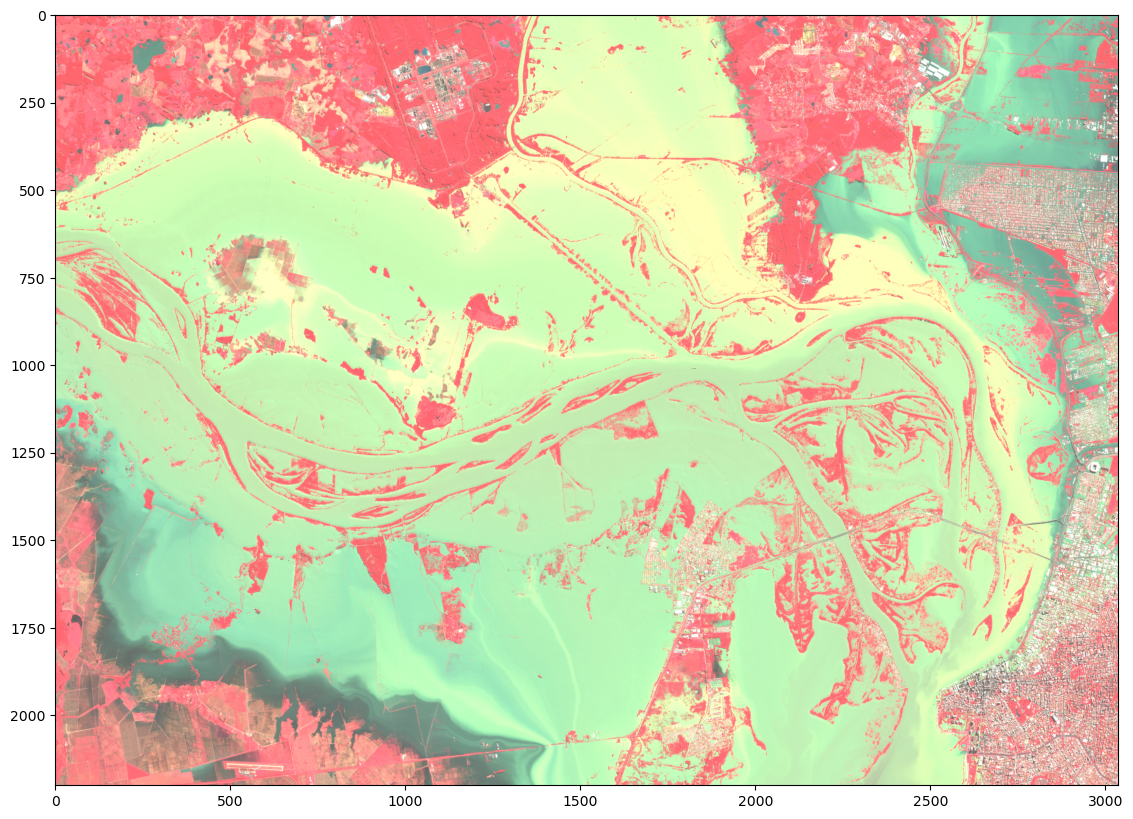

In [174]:
merge_ = merge[:,300:2500,5156:8192] 
# plt.figure(figsize=(15,10))
# plt.gray()
# plt.imshow(merge_[0,:,:]);

# Stack NIR-RG <- GR-NIR
merge_ = np.stack([merge_[2],merge_[1],
                  merge_[0]], axis=2)

print(merge_.shape)

rgbnir_t2_t1 = merge_ / merge_.max()
plt.figure(figsize=(15, 10))
plt.imshow(rgbnir_t2_t1*6)

In [175]:
#save image concatenated T4/T3/T2/T1, to create patches - GR-NIR
merge_crop = merge[:,300:2500,5156:8192]

merge.shape, merge_.shape, merge_crop.shape

((12, 10980, 10980), (2200, 3036, 3), (12, 2200, 3036))

Gerar mapa

In [176]:
##Importar biblioteca
import rasterio
from rasterio.plot import show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


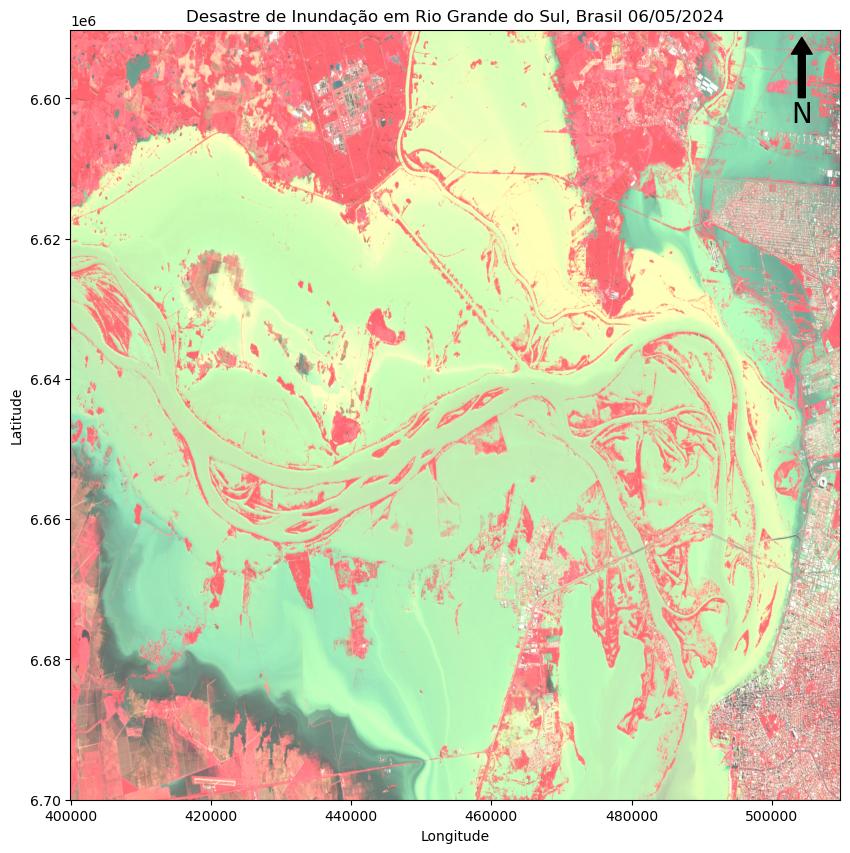

In [178]:
# Carregue a imagem raster com rasterio
path_to_raster = "Sentinel2_BGRNIR_2348_20240506.tif"
dataset = rasterio.open(path_to_raster)

# Ler os dados e a transformação do raster
data = dataset.read(1)  # Assumindo que é uma banda de dados
transform = dataset.transform

# Obter coordenadas de latitude e longitude para as bordas do raster
min_x, min_y = transform * (0, 0)
max_x, max_y = transform * (data.shape[1], data.shape[0])

# Plotar a imagem raster usando matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))

# Plotar o raster com imshow e integração com o plt
img = ax.imshow(rgbnir_t2_t1 * 6, cmap="terrain", extent=[min_x, max_x, min_y, max_y])
# plt.colorbar(img, label="Escala")

# Personalizar rótulos e título do gráfico
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Desastre de Inundação em Rio Grande do Sul, Brasil 06/05/2024")

# Inserir grids
# ax.grid(color='0.95', linestyle='dashed', linewidth=0.5, alpha=0.5)

# # Plotar box de informações
ax.text(0.5, 0.95,'',
        fontsize=12, transform=ax.transAxes, ha='center', va='center', bbox={'facecolor': 'white', 'pad': 10})

# Adicionar a orientação do norte
x, y, arrow_length = 0.95, 0.99, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Mostrar o gráfico na tela
plt.show()

In [10]:
dataset = gdal.Open("Sentinel2_BGRNIR_2348_20240506.tif", gdal.GA_ReadOnly)
GT = dataset.GetGeoTransform()
print(GT)

(399960.0, 10.0, 0.0, 6700000.0, 0.0, -10.0)


/home/cesar/anaconda3/envs/rsgislib/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### 3.1: Transf Affine

In [11]:
from affine import Affine

af_transf = Affine.from_gdal(*GT)
print(af_transf)

| 10.00, 0.00, 399960.00|
| 0.00,-10.00, 6700000.00|
| 0.00, 0.00, 1.00|


In [12]:
dataset = rasterio.open('Sentinel2_BGRNIR_2348_20240506.tif')
print(dataset.profile)
dataset = rasterio.open('Sentinel2_BGRNIR_2348_20240203.tif')
print(dataset.profile)
dataset = rasterio.open('Sentinel2_BGRNIR_2348_20240114.tif')
print(dataset.profile)
dataset = rasterio.open('Sentinel2_BGRNIR_2348_20231228.tif')
print(dataset.profile)
dst_crs = 'EPSG:32722'

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 4, 'crs': CRS.from_epsg(32722), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 6700000.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 4, 'crs': CRS.from_epsg(32722), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 6700000.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 4, 'crs': CRS.from_epsg(32722), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 6700000.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 4, 'crs': CRS.from_epsg(32722), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 6700000.0), 'blockysize': 1, 'tiled': Fal

In [187]:
merge_crop.shape

(12, 2200, 3036)

In [188]:
# SAVE
with rasterio.open(
    'raster_out_concatenate_charter_4t.tif',
    'w',
    driver='GTiff',
    height=merge_crop.shape[1],
    width=merge_crop.shape[2],
    count=merge_crop.shape[0],
    dtype=np.float32,
    crs=dst_crs,
    transform=af_transf,
) as dest_file:
    dest_file.write(merge_crop)
dest_file.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(12, 2200, 3036)
(2200, 3036, 3)


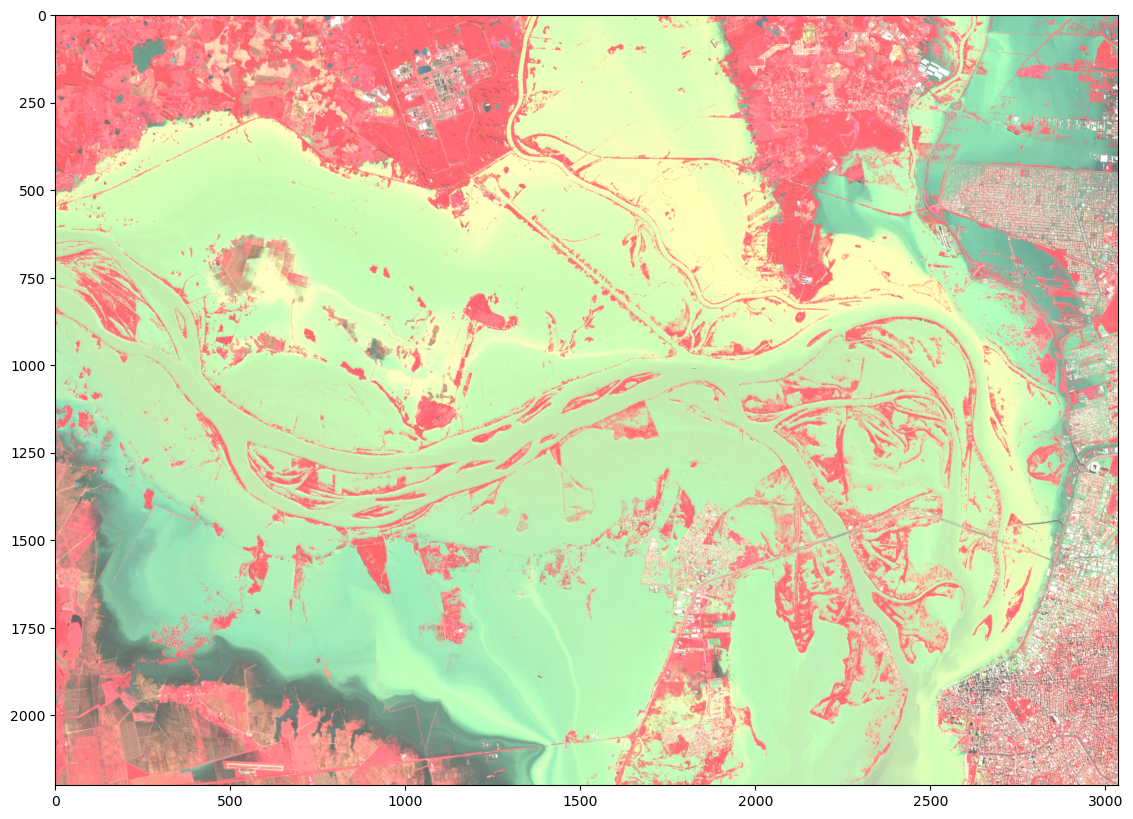

In [189]:
img_concat_array = rasterio.open('raster_out_concatenate_charter_4t.tif').read()
print(img_concat_array.shape)
# Stack NIR-RG - 12 channels
img_concat_array = np.stack([img_concat_array[2],img_concat_array[1],
                  img_concat_array[0]], axis=2)

print(img_concat_array.shape)

concat_t2_t1 = img_concat_array / img_concat_array.max()
plt.figure(figsize=(15, 10))
plt.imshow(concat_t2_t1*6)

In [190]:
dataset_concatenate = gdal.Open("raster_out_concatenate_charter_4t.tif", gdal.GA_ReadOnly)
GT_concatenate = dataset_concatenate.GetGeoTransform()
print(GT_concatenate)

(399960.0, 10.0, 0.0, 6700000.0, 0.0, -10.0)


## 3.2 : Após criar coluna de deslizamento e não-deslizamento na tabela de atributos, foi feito a conversão de shapefile para raster, criar patches de rótulos 64 x 64.

In [191]:
# !pip install --upgrade --no-cache-dir gdown

In [192]:
# Classes criadas pelo módulo para converter shapefile em raster
# Usar classes feitas pelo QGIS
# !gdown --id 17FHsd7KluFey3yyCyQV90_SC369fjqHv

(1, 2200, 3036)

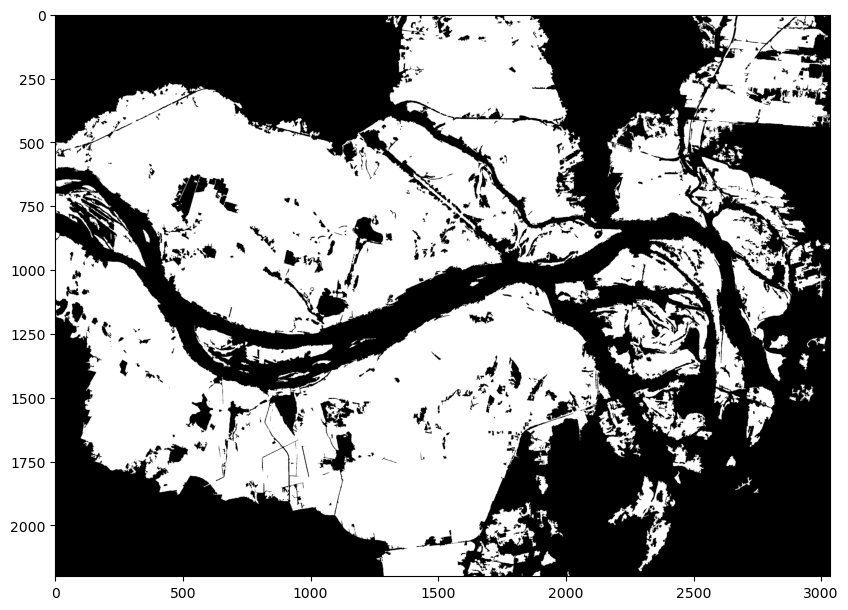

In [6]:
img = rasterio.open('Sentinel2_classes.tif').read()
img_crop = img[:,300:2500,5156:8192] ##[:,300:2500,5156:8192] <-melhor balanceado #img_crop = img[:,10:3000,5000:8400] 
plt.figure(figsize=(10, 10))
plt.imshow(img_crop[0,:,:], cmap='gray');
img_crop.shape

### Pixels com inundação e com não inundação

import numpy as np

# Contar quantos pixels são 0 e quantos são 1
num_zeros = np.count_nonzero(img_crop == 0)
num_ones = np.count_nonzero(img_crop == 1)

# Exibir os resultados
print(f'Número de pixels com valor 0: {num_zeros}')
print(f'Número de pixels com valor 1: {num_ones}')

In [8]:
img_crop.shape, num_zeros+num_ones, img_crop.shape[1]*img_crop.shape[2] #todos os pixels 0s e 1s, largura x altura

((1, 2200, 3036), 6679200, 6679200)

In [13]:
# SAVE
with rasterio.open(
    'floods_classes.tif',
    'w',
    driver='GTiff',
    height=img_crop.shape[1],
    width=img_crop.shape[2],
    count=img_crop.shape[0],
    dtype=np.float32,
    crs=dst_crs,
    transform=af_transf,
) as dest_file:
    dest_file.write(img_crop)
dest_file.close()

In [14]:
dataset_concatenate = gdal.Open("floods_classes.tif", gdal.GA_ReadOnly)
GT_concatenate = dataset_concatenate.GetGeoTransform()
print(GT_concatenate)

(399960.0, 10.0, 0.0, 6700000.0, 0.0, -10.0)


In [ ]:
img = rasterio.open('floods_classes.tif').read()
plt.figure(figsize=(8, 8))
plt.imshow(img[0,:,:], cmap='gray')
print(img.shape)

img_concat_array = rasterio.open('raster_out_concatenate_charter_4t.tif').read()
# Stack RGB NIR - 16 channels
img_concat_array = np.stack([img_concat_array[2],img_concat_array[1],
                  img_concat_array[0],img_concat_array[3]], axis=2)

print(img_concat_array.shape)

concat_t2_t1 = img_concat_array / img_concat_array.max()
plt.figure(figsize=(8, 8))
plt.imshow(concat_t2_t1*6)

## Patches com Systematic

In [16]:
from osgeo import gdal
def systematic(tif_path, pixelX=None, pixelY=None, tamX=None,
                    tamY=None, sobras=False):
    """
    Função para criação de patches conforme parâmetros escolhidos pelo usuário.

    patch_generator(tif_path, pixelX=None, pixelY=None, tamX=None,
                    tamY=None, sobras = False)


    tif_path: Deve ser inserida uma string com o
    diretório onde a imagem raster está inserida.
    ex: '/content/crop_rapideye.tif'


    pixelX: Deve ser inserido um valor inteiro com
    a dimensão desejada para o eixo X do patche.
    (Dimensão X do Patche em pixels)
    ex: 300

    pixelY: Deve ser inserido um valor inteiro com
    a dimensão desejada para o eixo Y do patche.
    (Dimensão Y do Patche em pixels)
    ex: 300

    tamX: Deve ser inserido um valor inteiro, em metros, da
    dimensão desejada para o eixo X do patche.
    (Dimensão X do Patche em metros)
    ex: 1500

    tamY: Deve ser inserido um valor inteiro, em metros, da
    dimensão desejada para o eixo Y do patche
    (Dimensão Y do Patche em metros)
    ex: 1500

    sobras: Quando True irá gerar recortes das bordas, caso estas
    apresentem dimensões inferiores às inseridas pelo usuário


    Exemplo de aplicação:
    Por exemplo, inserindo os seguintes parâmetros...

    patch_generator('/content/crop_rapideye.tif', pixelX=300, pixelY=300)

    Serão criados patches de 300x300 pixels do raster
    crop_rapideye.tif
    """

    raster = gdal.Open(tif_path)

    # Coletando os dados do raster
    gt = raster.GetGeoTransform()
    name = raster.GetDescription()
    name = name.split('.')[-2]

    # Separando os valores da lista gt
    # Coleta da coordenada x do canto superior esquerdo
    img_xmin = gt[0]
    # Coleta da coordenada y do canto superior esquerdo
    img_ymax = gt[3]
    # Coleta da resolução da imagem
    res = gt[1]

    # Verificandoo tamanho da imagem nos eixos x e y.
    # n_pixelsx é o numero de pixels na dimensão x
    # n_pixelsy é o numero de pixels na dimensão y
    n_pixelsx = raster.RasterXSize
    n_pixelsy = raster.RasterYSize

    # img_xlen é tamanho da imagem em metros na dimensão x
    # img_ylen é tamanho da imagem em metros na dimensão y
    img_xlen = res * n_pixelsx
    img_ylen = res * n_pixelsy


    # Delimitando o tamanho do patch

    # Caso o usuário insera o valor das dimensões do patch em pixels
    if pixelX != None and pixelY != None:
        # tamanho do patch em metros
        patch_xlen = pixelX * res
        patch_ylen = pixelY * res
        print(f'Tamanho do patch: {patch_xlen}m x {patch_ylen}m')

    # Caso o usuário insira o valor das dimensões do patch em metros
    elif  tamX != None and tamY != None:
        patch_xlen = tamX
        patch_ylen = tamY

    # Verificação do número de patches por eixo (dimensão total da imagem no eixo x // dimensão do patch em metros no eixo x)
    xdiv = img_xlen//patch_xlen
    # Verificação do número de patches por eixo (dimensão total da imagem no eixo y // dimensão do patch em metros no eixo y)
    ydiv = img_ylen//patch_ylen

    # Verificação do número total de patches
    total_patches= xdiv*ydiv
    print(f'Número total de patches ({pixelX} x {pixelY}) criados: {total_patches}')

    # Testando se o tamanho da imagem é proporcional ao tamanho do patch nas duas dimensões
    # Verificando se o tamanho do patch inserido pelo usuário é múltiplo da dimensão da imagem tif

    if img_xlen % patch_xlen != 0 or img_ylen % patch_ylen !=0:
        print(f'O tamanho da imagem não é múltiplo do tamanho do patch.\n')

       # Se o valor na dimensão x ou y não for divisível pela dimensão total da imagem, será aumentado
       # um valor no número de sobras
        if sobras:
            if img_xlen % patch_xlen != 0:
                xdiv += 1
            elif img_ylen % patch_ylen !=0:
                ydiv += 1
                t_patches= xdiv*ydiv
            print(f'Número total de patches a serem criados (+ sobras): {total_patches} patches + {t_patches - total_patches} sobras')

    # img_xmin = coord_x canto superior esquerdo; img_ymax = coord_y canto superior esquerdo;

    # Criação de uma lista com as coordenadas em x, através de uma list comprehension
    # com step de 0 até o número total de patches no eixo x(xdiv)
    xsteps = [img_xmin + patch_xlen*i for i in range(int(xdiv)+1)]

    # Criação de uma lista com as coordenadas em y, através de uma list comprehension
    # com step de 0 até o número total de patches no eixo y(xdiv)
    ysteps = [img_ymax - patch_ylen*i for i in range(int(ydiv)+1)]

    # Pergunta para o usuário, verificando se ele realmente quer fazer o número de patches
    # Esse passo é para evitar a criação de números demasiados de patches devido erro de digitação
    resp = 'S'  # input(f'Dejesa criar {total_patches} patches? (S/N)')

    # Se a respota for Sim (S), os patches serão criados
    if resp.upper() == 'S':
        # id = número inicial do nome atribuído a cada um dos patches, começando pelo 1
        id = 1
        # Criação de dois for aninhado para a definição das coordenadas de recorte
        for i in range(int(xdiv)):
            for j in range(int(ydiv)):
                # Coordenadas x (max/min) para o recorte, extraídas da lista de coordenadas criadas anteriormente (xsteps)
                xmin = xsteps[i]
                xmax = xsteps[i+1]
                # Coordenadas y (max/min) para o recorte, extraídas da lista de coordenadas criadas anteriormente (ysteps)
                ymax = ysteps[j]
                ymin = ysteps[j+1]

                gdal.Warp(name + '_' + 'p' + str(id) +'.tif', raster, outputBounds = (xmin, ymin, xmax, ymax), dstNodata = -9999)
                id += 1
        print(f'>> {total_patches} patches criados!')

    # Caso a resposta seja não (n), o programa não irá criar os patches
    elif resp.upper() == 'N':
        print('Programa finalizado, você optou por não criar nenhum patche.')
        print('-' * 100)

In [17]:
systematic('raster_out_concatenate_charter_4t.tif', pixelX=64, pixelY=64, sobras=False)

Tamanho do patch: 640.0m x 640.0m
Número total de patches (64 x 64) criados: 1598.0
O tamanho da imagem não é múltiplo do tamanho do patch.

>> 1598.0 patches criados!


In [18]:
!rm -rf patches_charter

In [19]:
# CRIA DIRETÓRIO E MOVE PATCHES PARA LÁ
!mkdir patches_charter
!mkdir patches_charter/cenas
!mv raster_out_concatenate_charter_4t_p*.tif patches_charter/cenas

In [20]:
systematic('floods_classes.tif', pixelX=64, pixelY=64, sobras=False)

Tamanho do patch: 640.0m x 640.0m
Número total de patches (64 x 64) criados: 1598.0
O tamanho da imagem não é múltiplo do tamanho do patch.

>> 1598.0 patches criados!


In [21]:
# CRIA DIRETÓRIO E MOVE PATCHES PARA LÁ
!mkdir patches_charter/classes
!mv floods_classes_p*.tif patches_charter/classes

## 3.4: Leitura e visualização dos dados

### 3.4.1: Bibliotecas necessárias
<hr style="border:1px solid #7D26CD">

In [2]:
import os
import glob
# Dados
import imgaug as ia
import imgaug.augmenters as iaa
import random
import PIL
from PIL import Image
from PIL import ImageOps

# Leitura das imagens
from skimage import io

import numpy as np
import time

import pandas as pd
from tensorflow.keras.preprocessing import image

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
# Gráficos
import matplotlib.pyplot as plt
import random
from imageio import mimread

tf.__version__

2024-11-06 12:18:26.823699: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 12:18:27.113692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 12:18:27.228481: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 12:18:27.261329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 12:18:27.454426: I tensorflow/core/platform/cpu_feature_guar

'2.17.0'

In [3]:
seed = 42
np.random.seed = seed
random.seed = seed
tf.random.set_seed(42)

In [4]:

sentinel2 = ['patches_charter/cenas',
          'patches_charter/classes']

# Função para leitura dos files
def read_image(image_path, mask=False):
    # Recebe os caminhos dos files
    img = io.imread(image_path)

    # Se for label a variável img receberá ela mesma
    if mask:
        # A imagem recebe apenas imagem
        img = img
    # Caso contrário,
    else:
        # se for patch o valores dos pixels é divido por 255
        img = img/255
    # A função retorna a imagem
    return img
# Organização da lista de rasters
# Lista: armazenará os paths de cada patch
org_path_pacth1 = []

# Loop: Acessa o diretório [0] para ler o paths
for raster in glob.iglob(sentinel2[0]+'/*.tif'):
    # Armazena o paths na lista
    org_path_pacth1.append(raster)
# Ordena os strings dos paths
org_path_pacth1.sort()

# Organização da lista de labels
#Lista: armazenará os paths de cada patch
org_path_label1 = []
# Loop: Acessa o diretório [1] para ler o paths
for raster in glob.iglob(sentinel2[1]+'/*.tif'):
    # Armazena o paths na lista
    org_path_label1.append(raster)
# Ordena os strings dos paths
org_path_label1.sort()
# Leitura e armazenamentos dos raster
# Lista: Armazenará as imagens
patche = []

# Loop: acessa cada path
for i in org_path_pacth1:
    # Leitura: chama a função de leitura
    imagem = read_image(i)
    # Armazena patches na lista
    patche.append(imagem)

# Leitura e armazenamentos dos labels
# Lista: Armazenará as imagens
label = []
# Loop: acessa cada path
for i in org_path_label1:
    # Leitura: chama a função de leitura
    mask = read_image(i, mask=True)

    new_mask = np.where(mask > 0, mask, 0)

    # Armazena labels na lista
    label.append(new_mask)

In [5]:
len(patche), len(label)

(1598, 1598)

In [6]:
# 40%  para teste e 60% para treinamento 
patche_cena_ = np.array(patche)
patche_classe_ = np.array(label)
len_patches_test = int(len(patche_classe_) * 0.6)  
print(len_patches_test)
# teste separado 40%
patche_cena_test = patche_cena_[len_patches_test:]
patche_classe_test = patche_classe_[len_patches_test:]
print('Ds para teste: ', patche_classe_test.shape)

patche_cena = patche_cena_[:len_patches_test]
patche_classe = patche_classe_[:len_patches_test]
print('Ds para treinamento: ', patche_classe.shape)

958
Ds para teste:  (640, 64, 64)
Ds para treinamento:  (958, 64, 64)


In [7]:
# variáveis para contar inundações e não inundações
floods = 0
no_floods = 0

for i in range(len(patche_classe_)):

  classe = patche_classe_[i]
  # print(classe)
  # Verifica valor diferente de 0 na matriz para inundações
  if np.any(classe != 0):
    floods += 1
  else:
    no_floods += 1
#quantidade de inundações e não inundações
print(f'Dataset original \nNúmeros de inundações: {floods}; Número de não-inundações: {no_floods}.')

Dataset original 
Números de inundações: 1228; Número de não-inundações: 370.


### 3.4.3: Visualizar patches das cenas e classes

In [8]:
# patche_cena_reshape = patche_cena.reshape(1860,64,64,16)
# print(patche_cena.shape, patche_cena_reshape.shape)
patche_cena.shape, patche_classe.shape

((958, 64, 64, 12), (958, 64, 64))

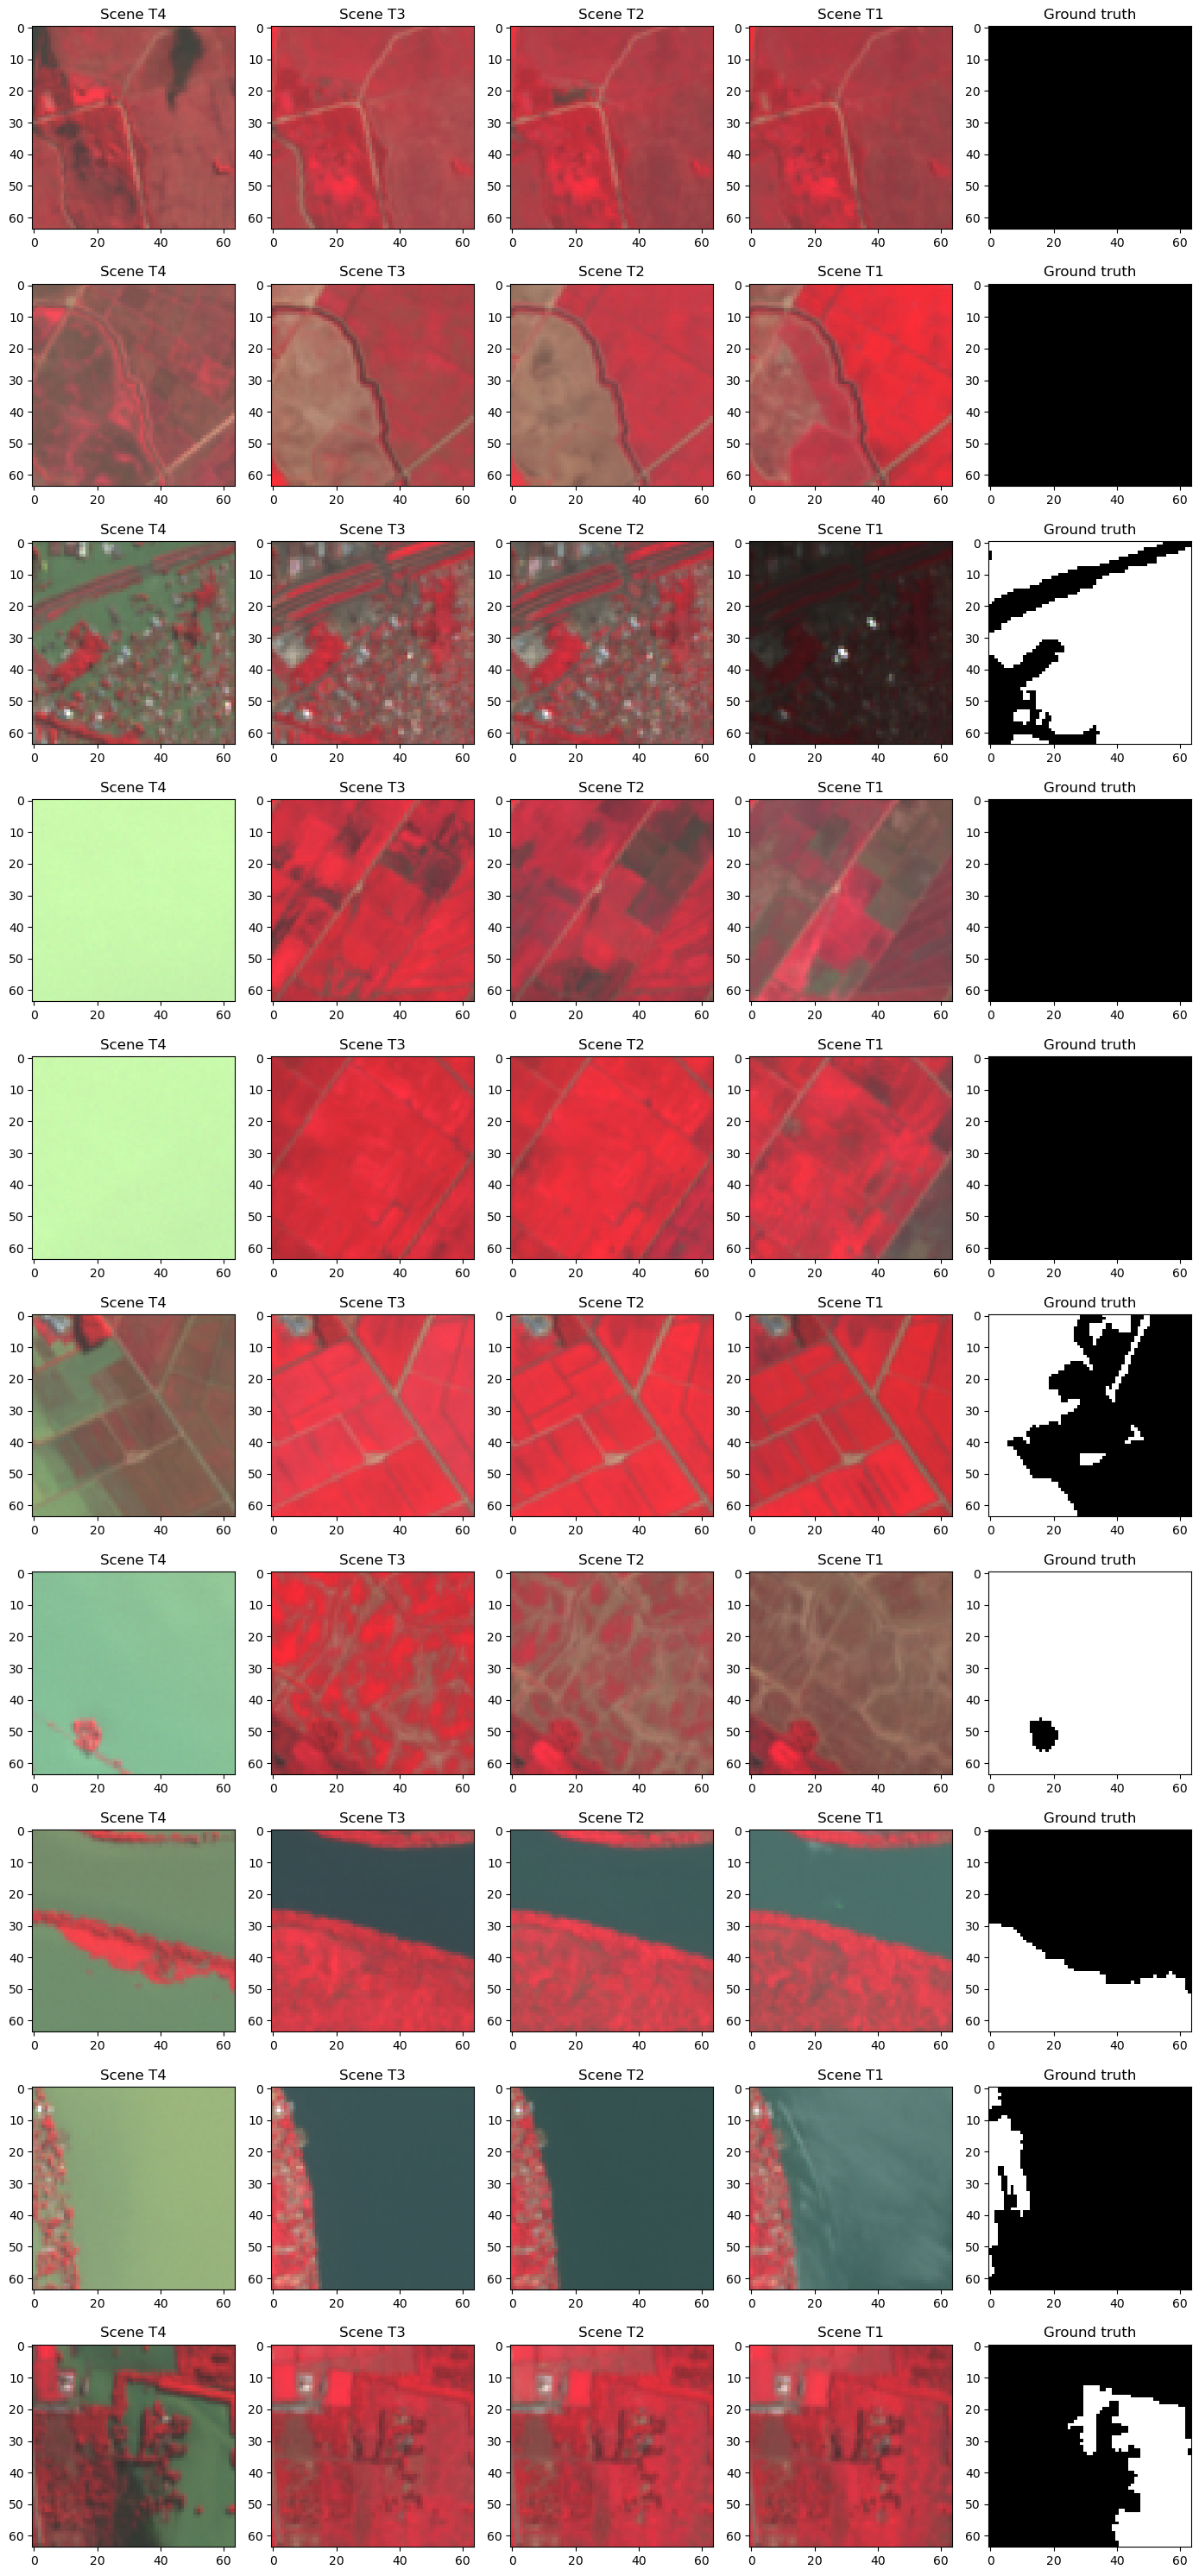

In [54]:
import matplotlib.pyplot as plt
import numpy as np


# Função para visualização das imagens
def visualize_images(num_rows, random_indices):
    fig, axes = plt.subplots(num_rows, 5, figsize=(14, 3*num_rows))

    for i in range(num_rows):
        idx = random_indices[i]

        # # Stack BGR NIR to RGB NIR - 16 channels -> 4 channels
        image_rgb_t1 = np.stack([patche_cena[idx, :, :, 11], patche_cena[idx, :, :, 10],
                                 patche_cena[idx, :, :, 9]], axis=2)
        
        image_rgb_t2 = np.stack([patche_cena[idx, :, :, 8], patche_cena[idx, :, :, 7],
                                 patche_cena[idx, :, :, 6]], axis=2)

        image_rgb_t3 = np.stack([patche_cena[idx, :, :, 5], patche_cena[idx, :, :, 4],
                                 patche_cena[idx, :, :, 3]], axis=2)

        image_rgb_t4 = np.stack([patche_cena[idx, :, :, 2], patche_cena[idx, :, :, 1],
                                 patche_cena[idx, :, :, 0]], axis=2)

        # Normalização das imagens NIR-RG
        image_rgb_t1 = image_rgb_t1 / image_rgb_t1.max()
        image_rgb_t2 = image_rgb_t2 / image_rgb_t2.max()
        image_rgb_t3 = image_rgb_t3 / image_rgb_t3.max()
        image_rgb_t4 = image_rgb_t4 / image_rgb_t4.max()

        # Predições
        ground_truth = np.squeeze(patche_classe[idx])

        # Plotar as imagens
        axes[i, 0].imshow(image_rgb_t4, cmap='gray')
        axes[i, 0].set_title('Scene T4')
        # axes[i, 0].axis('off')

        axes[i, 1].imshow(image_rgb_t3, cmap='gray')
        axes[i, 1].set_title('Scene T3')
        # axes[i, 1].axis('off')

        axes[i, 2].imshow(image_rgb_t2, cmap='gray')
        axes[i, 2].set_title('Scene T2')
        # axes[i, 0].axis('off')

        axes[i, 3].imshow(image_rgb_t1, cmap='gray')
        axes[i, 3].set_title('Scene T1')
        # axes[i, 0].axis('off')

        axes[i, 4].imshow(ground_truth, cmap='gray')
        axes[i, 4].set_title('Ground truth')
        # axes[i, 2].axis('off')


    plt.tight_layout()
    plt.show()

# Escolha aleatoriamente algumas imagens para visualizar
num_samples = 10
random_indices = np.random.randint(0, patche_cena.shape[0], num_samples)

# Visualizar as cenas e as classes lado a lado
visualize_images(num_samples, random_indices)


## 4: Tensorflow Keras
## Introdução
### Modelo de Segmentação Semântica utilizando Keras para classificação pixel a pixel de patches de imagens bitempotais de inundações da catastrofe do Rio Grande do Sul em 2024. A ideia desse projeto foi utilizar a  arquitetura de Segmentação Semântica TempCNN, usada para classificação de uso e cobertura da Terra, aplicanda neste estudo para o domínio de desastre de inundação.
<hr style="border:1px solid #7D26CD">

In [8]:
patche_cena.shape, patche_classe.shape  # ((958, 64, 64, 12), (958, 64, 64))

((958, 64, 64, 12), (958, 64, 64))

In [9]:
# variáveis para contar inundações e não inundações - treinamento (patche_classe)
floods = 0
no_floods = 0
# Listas de inundações e não-inundações dataset original
list_patches = []
list_patches_n = []
# laço de contagem
for i in range(len(patche_classe)): 

  # print(patche_classe[i])
  # Verifica valor diferente de -1 na matriz para deslizamento
  if np.any(patche_classe[i] >= 1):
    floods += 1
    list_patches.append(i)
  else:
    no_floods += 1
    list_patches_n.append(i)
#quantidade de inundações e não inundações
print('Treinamento')
print(f'Números de inundações: {floods}; Número de não-inundações: {no_floods}.')
print(f'Listas: \ninundações: {list_patches};\nNão-inundações: {list_patches_n}.')

Treinamento
Números de inundações: 681; Número de não-inundações: 277.
Listas: 
inundações: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 97, 101, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 135, 146, 147, 148, 149, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 172, 173, 179, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 206, 209, 210, 212, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 251, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274

In [10]:
# variáveis para contar inundações e não inundações - treinamento (patche_classe_test)
floods = 0
no_floods = 0
# Listas de inundações e não-inundações dataset original
list_patches = []
list_patches_n = []
# laço de contagem
for i in range(len(patche_classe_test)): 

  # print(patche_classe_test[i])
  # Verifica valor diferente de -1 na matriz para deslizamento
  if np.any(patche_classe_test[i] >= 1):
    floods += 1
    list_patches.append(i)
  else:
    no_floods += 1
    list_patches_n.append(i)
#quantidade de inundações e não inundações
print('Teste')

print(f'Números de inundações: {floods}; Número de não-inundações: {no_floods}.')
print(f'Listas: \ninundações: {list_patches};\nNão-inundações: {list_patches_n}.')

Teste
Números de inundações: 547; Número de não-inundações: 93.
Listas: 
inundações: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 63, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 174, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244, 245, 246, 247, 249, 256, 257, 258, 259, 260, 261, 262, 264, 265, 266, 267, 268, 269, 270, 271,

## 5: Construção da rede neural

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, CSVLogger
import os

#### 5.1.1: Função de perda de entropia cruzada.
##### É usada quando houver duas ou mais classes de rótulos. Esperando que os rótulos sejam fornecidos como ```números inteiros```. Se você quiser fornecer rótulos usando representação one-hot (propenso a criar muitos preditores), use CategoricalCrossentropy loss. Deve haver \# classes valores de ponto flutuante por recurso para y_pred e um único valor de ponto flutuante por recurso para y_true [4].

## 6: Treinamento com validação de 20%

In [12]:
# len(np.unique(train_label))
np.unique(patche_classe)  # salvando aumento de dados com dtype=uint8

array([0., 1.], dtype=float32)

In [13]:
patche_classe.shape,patche_cena.shape

((958, 64, 64), (958, 64, 64, 12))

In [14]:
# Reshape patche_cena
patche_cena_reshape = patche_cena.reshape(patche_cena.shape[0],patche_cena.shape[1],patche_cena.shape[2],patche_cena.shape[3])
patche_cena_reshape.shape  # (1860, 64, 64, 12)

(958, 64, 64, 12)

In [15]:
def criar_diretorio(caminho):
  if not os.path.exists(caminho):
    os.makedirs(caminho)
path_modelo = 'modelos'
criar_diretorio(path_modelo)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, CSVLogger
import os

In [17]:
callbacks = [ModelCheckpoint(path_modelo + '/modelo_drive_{epoch:02d}.keras', verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=10)]

In [18]:
from tensorflow.keras.backend import clear_session

# Limpar a sessão atual do Keras
clear_session()


In [19]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Fechar a sessão do TensorFlow
K.clear_session()

# Resetar a memória da GPU
tf.config.experimental.reset_memory_stats('GPU:0')


I0000 00:00:1730906391.482435   10351 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730906391.708991   10351 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730906391.716420   10351 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730906391.720794   10351 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [20]:
import tensorflow as tf
import keras
from keras import layers
from keras import optimizers
from keras.regularizers import l2
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Flatten, Lambda, SpatialDropout1D, Concatenate, Conv3D
from keras.layers import Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, GRU, Bidirectional
from keras.callbacks import Callback, ModelCheckpoint, History, EarlyStopping
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras import backend as K
import time
import numpy as np

In [21]:
def iou_metric(y_true, y_pred):
    # Caso y_pred esteja em formato de probabilidade, convertemos para rótulos de classe
    if y_pred.shape[-1] > 1:
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.expand_dims(y_pred, axis=-1)  # Expandir para corresponder a y_true

    if y_true.shape[-1] > 1:
        y_true = tf.argmax(y_true, axis=-1)
        y_true = tf.expand_dims(y_true, axis=-1)  # Expandir para corresponder a y_pred

    y_true = tf.cast(y_true, tf.int64)
    y_pred = tf.cast(y_pred, tf.int64)

    # Calcular interseção e união
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))

    return intersection / (union + tf.keras.backend.epsilon())

tf.keras.utils.get_custom_objects().update({"iou_metric": iou_metric})

In [22]:
def softmax(X, nbclasses, **params):
    kernel_regularizer = params.setdefault("kernel_regularizer", l2(1.e-5))
    kernel_initializer = params.setdefault("kernel_initializer", "glorot_uniform")
    return Dense(nbclasses, activation='softmax',
                 kernel_initializer=kernel_initializer,
                 kernel_regularizer=kernel_regularizer)(X)


def conv3d_bn_relu_drop(x, nbunits, kernel_size, kernel_regularizer, dropout_rate):
    x = Conv3D(nbunits, kernel_size, padding='same', kernel_regularizer=kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    return x

def Archi_TempCNN(input_shape, nbclasses):
    l2_rate = 1.e-6
    dropout_rate = 0.42

    nb_conv = 3
    nbunits_conv = 64

    X_input = Input(input_shape)
    X = X_input
    for _ in range(nb_conv):
        X = conv3d_bn_relu_drop(X, nbunits=nbunits_conv, kernel_size=(3, 3, 3), kernel_regularizer=l2(l2_rate), dropout_rate=dropout_rate)
    # out = Conv3D(filters=nbclasses, kernel_size=(1, 1, 1), activation='softmax', kernel_regularizer=l2(l2_rate))(X)

    # Camada SOFTMAX
    out = softmax(X, nbclasses, kernel_regularizer=l2(l2_rate))

    # Criar o modelo
    return Model(inputs=X_input, outputs=out, name='Archi_TempCNN')



In [23]:
import numpy as np
from tensorflow.keras.utils import to_categorical

def one_hot_encode_labels(labels, num_classes):
    return np.expand_dims(to_categorical(labels, num_classes=num_classes), axis=1)


def reshape_data(X, target_channels):
    """
    Reorganiza os dados para a forma com base no número de canais.
    """
    # Verifique a forma atual
    n_samples = X.shape[0]
    height = X.shape[1]
    width = X.shape[2]
    current_channels = X.shape[3]

    # Verifique se o número de canais especificado é compatível
    if current_channels != target_channels:
        raise ValueError("O número de canais especificado não é compatível com a forma dos dados.")

    # Adicione uma dimensão de tempo fictícia se necessário (por exemplo, para uma rede com dimensão temporal)
    return X.reshape(n_samples, 1, height, width, current_channels)  # Adiciona uma dimensão de tempo


In [24]:
## Cross validation

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

# Configuração
num_folds = 5
n_bands = 12
input_shape = (1, 64, 64, n_bands)
nbclasses = 2 

# Função para preparar os dados
def preparar_dados(patche_cena, patche_classe, num_classes):
    y_onehot = one_hot_encode_labels(patche_classe, num_classes)
    X_reshaped = reshape_data(patche_cena, n_bands)
    return X_reshaped, y_onehot

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=num_folds)

# Armazenar resultados
all_scores = []
histories = []

# K-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(tscv.split(patche_cena_)):
    print(f'Fold {fold+1}/{num_folds}')

    X_train, X_val = patche_cena_[train_index], patche_cena_[val_index]
    y_train, y_val = patche_classe_[train_index], patche_classe_[val_index]

    # Preparar os dados
    X_train_reshaped, y_train_onehot = preparar_dados(X_train, y_train, nbclasses)
    X_val_reshaped, y_val_onehot = preparar_dados(X_val, y_val, nbclasses)

    # Criar e compilar o modelo
    model = Archi_TempCNN(input_shape, nbclasses)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', iou_metric])

    # Definir callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10),
        ModelCheckpoint(f'model_fold_{fold+1}.keras', save_best_only=True)
    ]

    # Treinar o modelo
    history = model.fit(X_train_reshaped, y_train_onehot,
                        validation_data=(X_val_reshaped, y_val_onehot),
                        epochs=100,
                        batch_size=32,
                        callbacks=callbacks,
                        verbose=1)

    # Armazenar o histórico de treinamento
    histories.append(history.history)

    # Avaliar o modelo
    scores = model.evaluate(X_val_reshaped, y_val_onehot, verbose=0)
    print(f'Fold {fold+1} - Loss: {scores[0]}, Accuracy: {scores[1]}, IoU: {scores[2]}')
    all_scores.append(scores)

    # Limpar o modelo para o próximo fold
    K.clear_session()

# Calcular a média dos resultados após a validação cruzada
all_scores = np.array(all_scores)
media_loss = np.mean(all_scores[:, 0])
media_accuracy = np.mean(all_scores[:, 1])
media_iou = np.mean(all_scores[:, 2])

print(f'Média do Loss após validação cruzada: {media_loss}')
print(f'Média da Accuracy após validação cruzada: {media_accuracy}')
print(f'Média da IoU após validação cruzada: {media_iou}')


Fold 1/5
Epoch 1/100


I0000 00:00:1730906439.563100   30972 service.cc:146] XLA service 0x7ff0a8023d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730906439.563125   30972 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-11-06 12:20:39.635242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-06 12:20:39.914562: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


2/9 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5829 - iou_metric: 0.3334 - loss: 0.8134

I0000 00:00:1730906446.552016   30972 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 933ms/step - accuracy: 0.7414 - iou_metric: 0.5363 - loss: 0.5592 - val_accuracy: 0.4447 - val_iou_metric: 0.4389 - val_loss: 2.4615
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8943 - iou_metric: 0.7484 - loss: 0.3308 - val_accuracy: 0.6585 - val_iou_metric: 0.4927 - val_loss: 1.6790
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.8980 - iou_metric: 0.7499 - loss: 0.2772 - val_accuracy: 0.6766 - val_iou_metric: 0.5044 - val_loss: 1.2573
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9079 - iou_metric: 0.7738 - loss: 0.2573 - val_accuracy: 0.6977 - val_iou_metric: 0.5474 - val_loss: 0.9748
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9076 - iou_metric: 0.7742 - loss: 0.2457 - val_accuracy: 0.7152 - val_iou_metric: 0.5887 - val_loss: 0.8220
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9094 - iou_metric: 0.7771 - loss: 0.2409 - val_accuracy: 0.7068 - val_iou_metric: 0.59

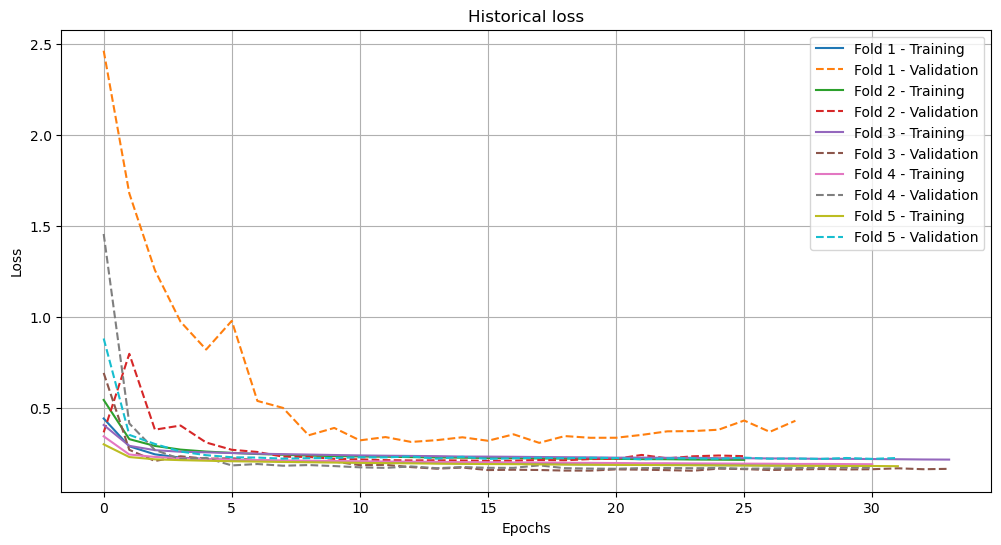

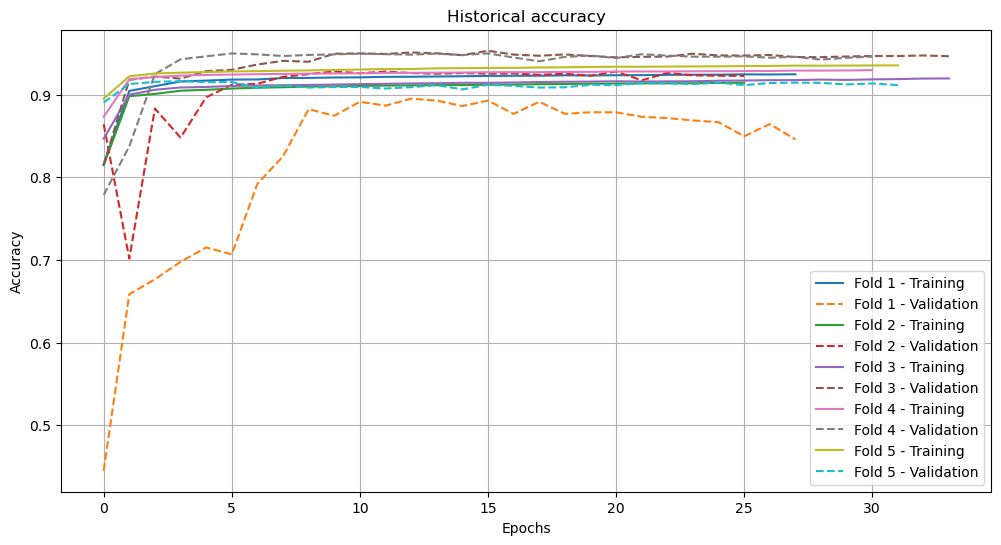

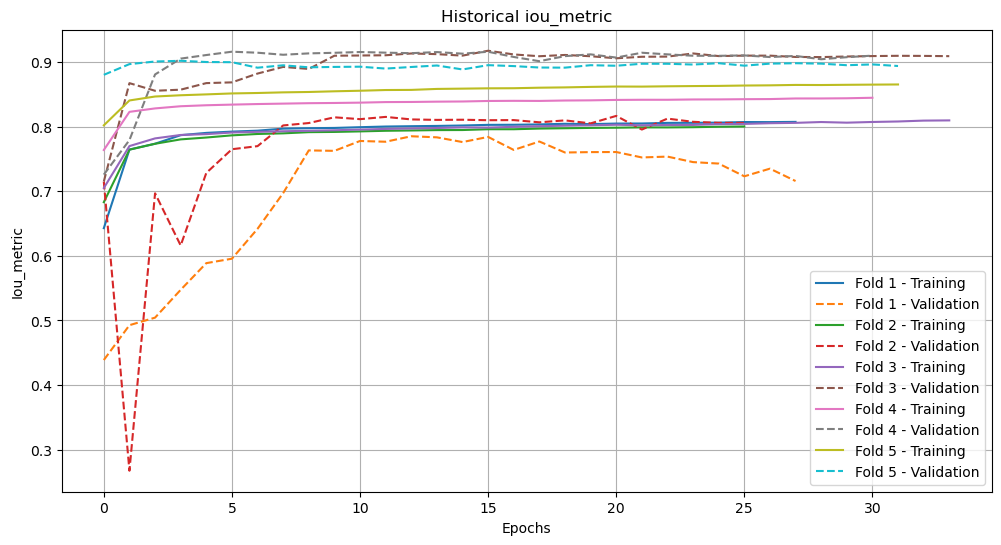

In [26]:
import matplotlib.pyplot as plt

# Função para plotar gráficos de histórico
def plot_histories(histories, metric):
    plt.figure(figsize=(12, 6))
    for i, history in enumerate(histories):
        plt.plot(history[metric], label=f'Fold {i+1} - Training')
        plt.plot(history[f'val_{metric}'], label=f'Fold {i+1} - Validation', linestyle='--')
    plt.title(f'Historical {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotar gráficos para Loss, Accuracy e IoU
plot_histories(histories, 'loss')
plot_histories(histories, 'accuracy')
plot_histories(histories, 'iou_metric') 

### importante fazer 5 predições, uma para cada modelo em seu k-fold gerado (e salvo) para prever o dataset de inferência. Ao final mostrar uma média das métricas e também um desvio padrão, para uma melhor avaliação do desempenho do modelo

In [27]:
# One-hot encoding das labels
nbclasses = 2  # Ajuste o número de classes conforme necessário

y_train_onehot = one_hot_encode_labels(patche_classe, nbclasses)

n_bands = 12
# Aplicar a função
X_train_reshaped = reshape_data(patche_cena_reshape, n_bands)

print('Forma de y_train após onehot:', y_train_onehot.shape)
print('Forma de X_train após reshape:', X_train_reshaped.shape)

Forma de y_train após onehot: (958, 1, 64, 64, 2)
Forma de X_train após reshape: (958, 1, 64, 64, 12)


In [28]:
# Definir o input_shape e o número de classes
l_patche = 64
input_shape = (1, l_patche, l_patche, n_bands)  # Ajuste conforme necessário
nbclasses = 2  # Ajuste conforme necessário

# Criar o modelo TempCNN
model = Archi_TempCNN(input_shape, nbclasses)

# Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', iou_metric])

# Exibir o resumo do modelo
model.summary()

callbacks = [ModelCheckpoint(path_modelo + '/modelo_drive_{epoch:02d}.keras', verbose=1, save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=10)]

# Treinar o modelo
history = model.fit(X_train_reshaped, y_train_onehot,
                    validation_split=0.2,
                    epochs=100,  # Ajuste o número de épocas conforme necessário
                    batch_size=32,  # Ajuste o tamanho do batch conforme necessário
                    callbacks=callbacks,
                    verbose=1)

# history = model.fit(patche_cena_combined,patche_classe_combined,batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=callbacks)


Model: "Archi_TempCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 64, 64, 12)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 1, 64, 64, 64)  │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 64, 64, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 1, 64, 64, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 64, 64, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 1, 64, 64, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 64, 64, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64, 64, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 64, 64, 2)   │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,010 (949.26 KB)

 Trainable params: 242,626 (947.76 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7299 - iou_metric: 0.5770 - loss: 0.5849
Epoch 1: val_loss improved from inf to 0.25513, saving model to modelos/modelo_drive_01.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.7343 - iou_metric: 0.5820 - loss: 0.5782 - val_accuracy: 0.9185 - val_iou_metric: 0.8503 - val_loss: 0.2551
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9057 - iou_metric: 0.7757 - loss: 0.2876
Epoch 2: val_loss did not improve from 0.25513
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9059 - iou_metric: 0.7762 - loss: 0.2870 - val_accuracy: 0.9349 - val_iou_metric: 0.8710 - val_loss: 0.2571
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9085 - iou_metric: 0.7824 - loss: 0.2603
Epoch 3: val_loss did not improve from 0.25513
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9086 - iou_metric: 0.7828 - loss: 0.2601 - val_accuracy: 0.9048 - val_iou_metric: 0.8338 - val_loss: 0.2770
Ep

In [29]:
history.history.keys()

dict_keys(['accuracy', 'iou_metric', 'loss', 'val_accuracy', 'val_iou_metric', 'val_loss'])

In [30]:
patche_cena_reshape.shape

(958, 64, 64, 12)

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_acc(history):
    fig = plt.gcf()
    fig.set_size_inches(8, 4)
    plt.subplot(1, 1, 1)
    plt.plot(history.history['accuracy'], 'red', label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def plot_loss(history):
    fig = plt.gcf()
    fig.set_size_inches(8, 4)
    plt.subplot(1, 1, 1)
    plt.plot(history.history['loss'], 'red', label='Training Loss')
    plt.plot(history.history['val_loss'], 'blue', label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def plot_iou_metric(history):
    fig = plt.gcf()
    fig.set_size_inches(8, 4)
    plt.subplot(1, 1, 1)
    plt.plot(history.history['iou_metric'], 'red', label='Training IoU')
    plt.plot(history.history['val_iou_metric'], 'blue', label='Validation IoU')
    plt.legend()
    plt.title('IoU')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

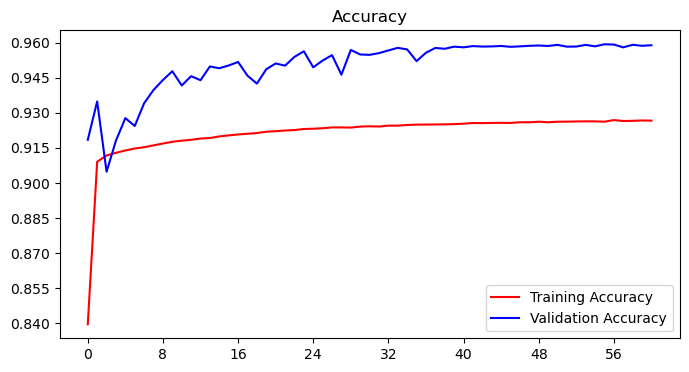

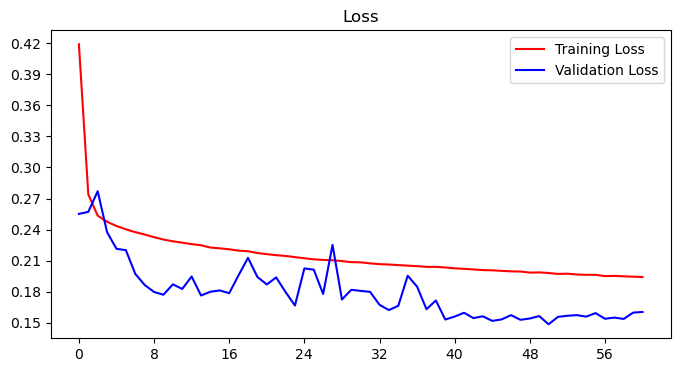

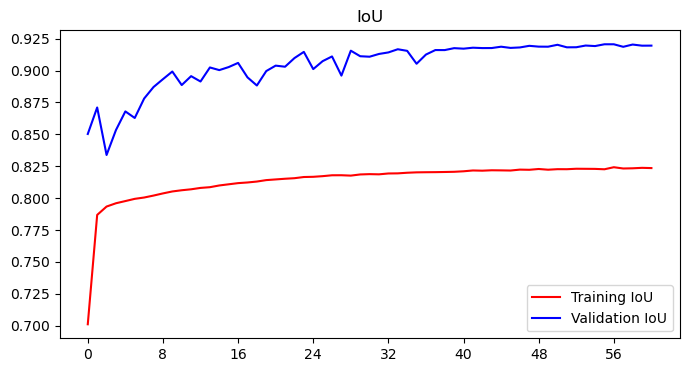

In [32]:
plot_acc(history)
plot_loss(history)
plot_iou_metric(history)

In [33]:
n_bands = 12
# Aplicar a função reshaped
patche_cena_test_reshaped = reshape_data(patche_cena_test, n_bands)
# Predição
y_pred = model.predict(patche_cena_test_reshaped)
y_pred_argmax = np.argmax(y_pred, axis=-1)  # Predições em termos de classe

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [51]:
# REMOVER COMENTÁRIOS PARA VER 180 PATCHES COM SUAS PREDIÇÕES
# import matplotlib.pyplot as plt
# import numpy as np


# # Função para visualização das imagens
# def visualize_images(num_rows):
#     fig, axes = plt.subplots(num_rows, 6, figsize=(14, 3*num_rows))

#     for i in range(num_rows):
#         idx = i

#         # # Stack BGR NIR to RGB NIR - 12 channels -> 3 channels
#         image_rgb_t1 = np.stack([patche_cena_test[idx, :, :, 11], patche_cena_test[idx, :, :, 10],
#                                  patche_cena_test[idx, :, :, 9]], axis=2)
        
#         image_rgb_t2 = np.stack([patche_cena_test[idx, :, :, 8], patche_cena_test[idx, :, :, 7],
#                                  patche_cena_test[idx, :, :, 6]], axis=2)

#         image_rgb_t3 = np.stack([patche_cena_test[idx, :, :, 5], patche_cena_test[idx, :, :, 4],
#                                  patche_cena_test[idx, :, :, 3]], axis=2)

#         image_rgb_t4 = np.stack([patche_cena_test[idx, :, :, 2], patche_cena_test[idx, :, :, 1],
#                                  patche_cena_test[idx, :, :, 0]], axis=2)

#         # Normalização das imagens RGB
#         image_rgb_t1 = image_rgb_t1 / image_rgb_t1.max()
#         image_rgb_t2 = image_rgb_t2 / image_rgb_t2.max()
#         image_rgb_t3 = image_rgb_t3 / image_rgb_t3.max()
#         image_rgb_t4 = image_rgb_t4 / image_rgb_t4.max()

#         # Predições
#         ground_truth = np.squeeze(patche_classe_test[idx])
#         predict = np.squeeze(y_pred_argmax[idx])

#         # Plotar as imagens
#         axes[i, 0].imshow(image_rgb_t4, cmap='gray')
#         axes[i, 0].set_title('Scene T4')
#         # axes[i, 0].axis('off')

#         axes[i, 1].imshow(image_rgb_t3, cmap='gray')
#         axes[i, 1].set_title('Scene T3')
#         # axes[i, 1].axis('off')

#         axes[i, 2].imshow(image_rgb_t2, cmap='gray')
#         axes[i, 2].set_title('Scene T2')
#         # axes[i, 0].axis('off')

#         axes[i, 3].imshow(image_rgb_t1, cmap='gray')
#         axes[i, 3].set_title('Scene T1')
#         # axes[i, 0].axis('off')

#         axes[i, 4].imshow(ground_truth, cmap='gray')
#         axes[i, 4].set_title('Ground truth')
#         # axes[i, 2].axis('off')

#         axes[i, 5].imshow(predict, cmap='gray')
#         axes[i, 5].set_title(f'Predict - {idx}')
#         # axes[i, 3].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Escolha aleatoriamente algumas imagens para visualizar
# num_samples = 180
# # random_indices = np.random.randint(0, patche_cena_test.shape[0], num_samples)

# # Visualizar as cenas e as classes lado a lado
# visualize_images(num_samples)


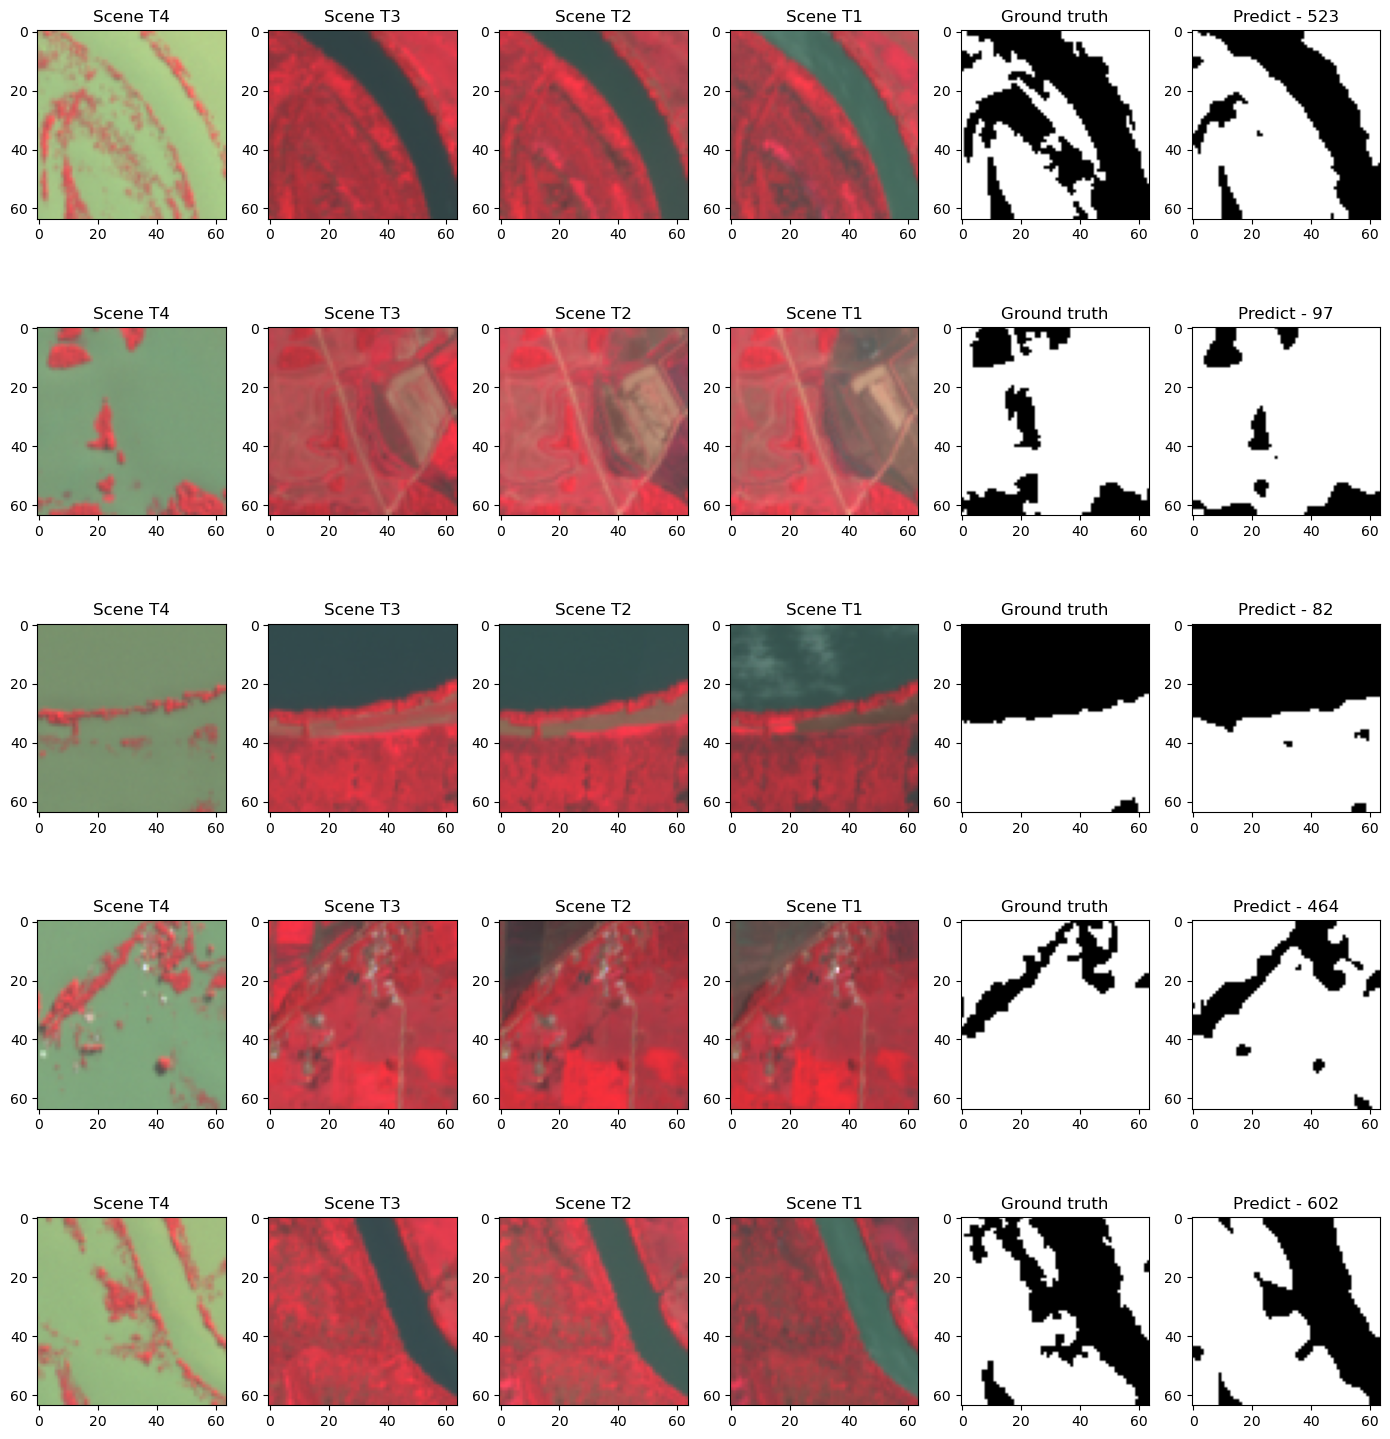

In [37]:
import matplotlib.pyplot as plt
import numpy as np


# Função para visualização das imagens
def visualize_images(num_rows, random_indices):
    fig, axes = plt.subplots(num_rows, 6, figsize=(14, 3*num_rows))

    for i in range(num_rows):
        idx = random_indices[i]

        # # Stack BGR NIR to RGB NIR - 12 channels -> 3 channels
        image_rgb_t1 = np.stack([patche_cena_test[idx, :, :, 11], patche_cena_test[idx, :, :, 10],
                                 patche_cena_test[idx, :, :, 9]], axis=2)
        
        image_rgb_t2 = np.stack([patche_cena_test[idx, :, :, 8], patche_cena_test[idx, :, :, 7],
                                 patche_cena_test[idx, :, :, 6]], axis=2)

        image_rgb_t3 = np.stack([patche_cena_test[idx, :, :, 5], patche_cena_test[idx, :, :, 4],
                                 patche_cena_test[idx, :, :, 3]], axis=2)

        image_rgb_t4 = np.stack([patche_cena_test[idx, :, :, 2], patche_cena_test[idx, :, :, 1],
                                 patche_cena_test[idx, :, :, 0]], axis=2)

        # Normalização das imagens RGB
        image_rgb_t1 = image_rgb_t1 / image_rgb_t1.max()
        image_rgb_t2 = image_rgb_t2 / image_rgb_t2.max()
        image_rgb_t3 = image_rgb_t3 / image_rgb_t3.max()
        image_rgb_t4 = image_rgb_t4 / image_rgb_t4.max()

        # Predições
        ground_truth = np.squeeze(patche_classe_test[idx])
        predict = np.squeeze(y_pred_argmax[idx])

        # Plotar as imagens
        axes[i, 0].imshow(image_rgb_t4, cmap='gray')
        axes[i, 0].set_title('Scene T4')
        # axes[i, 0].axis('off')

        axes[i, 1].imshow(image_rgb_t3, cmap='gray')
        axes[i, 1].set_title('Scene T3')
        # axes[i, 1].axis('off')

        axes[i, 2].imshow(image_rgb_t2, cmap='gray')
        axes[i, 2].set_title('Scene T2')
        # axes[i, 0].axis('off')

        axes[i, 3].imshow(image_rgb_t1, cmap='gray')
        axes[i, 3].set_title('Scene T1')
        # axes[i, 0].axis('off')

        axes[i, 4].imshow(ground_truth, cmap='gray')
        axes[i, 4].set_title('Ground truth')
        # axes[i, 2].axis('off')

        axes[i, 5].imshow(predict, cmap='gray')
        axes[i, 5].set_title(f'Predict - {idx}')
        # axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Escolha aleatoriamente algumas imagens para visualizar
num_samples = 5
random_indices = [523,97,82,464,602]  #np.random.randint(0, patche_cena_test.shape[0], num_samples)

# Visualizar as cenas e as classes lado a lado
visualize_images(num_samples, random_indices)


In [35]:
# Delete variáveis
# del patche_cena, patche_classe, patche_cena_, patche_cena_augmented, patche_classe_augmented, patche_cena_combined, patche_classe_combined

## 7: F1-Score e Acurácia do Teste

In [38]:
# Teste separando patchs e labels do dataset
# F1-Score:
f1 = f1_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()), average='weighted')
print("F1-Score: ", f1)

# Accuracy:
acc = accuracy_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()))
print("Accuracy: ", acc)

F1-Score:  0.9359244778409703
Accuracy:  0.9361976623535156


## 8: Métrica IoU [2]

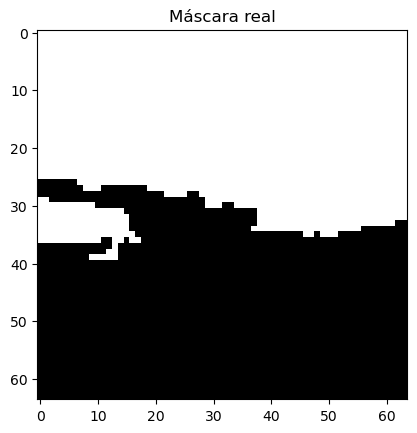

In [37]:
id_img_teste = 120
img_teste = patche_cena_test[id_img_teste]
ground_truth = patche_classe_test[id_img_teste]
plt.imshow(np.squeeze(ground_truth), cmap='gray')
plt.title('Máscara real');

In [38]:
from tensorflow.keras.metrics import MeanIoU
iou_resultado = MeanIoU(num_classes = 2)

In [39]:
img_teste.shape

(64, 64, 12)

In [40]:
img_teste_expanded = img_teste.reshape(1, 64, 64, n_bands)
print(img_teste_expanded.shape)

(1, 64, 64, 12)


In [41]:
# img_test = img_test / 255.0  # Normalização no intervalo [0, 1]

In [42]:
# Ajustar a forma da imagem para (1, 1, 64, 64, 12) - incluindo a dimensão temporal
img_teste_expanded = np.expand_dims(img_teste, axis=0)  # Forma: (1, 64, 64, 12)
img_teste_expanded = np.expand_dims(img_teste_expanded, axis=0)  # Forma: (1, 1, 64, 64, 12)

# Verificar a forma da imagem expandida
print("Forma da imagem de teste expandida:", img_teste_expanded.shape)

# Realizar a predição
try:
    predictions = model.predict(img_teste_expanded)  # Forma: (1, 64, 64, num_classes)
except Exception as e:
    print("Erro ao realizar a predição:", e)
    raise


Forma da imagem de teste expandida: (1, 1, 64, 64, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


In [43]:
predictions = tf.argmax(predictions, axis=-1)

In [44]:
ground_truth = ground_truth.reshape(1, 64, 64, 1)

In [45]:
ground_truth = tf.cast(ground_truth, tf.int64)

In [46]:
iou_resultado.update_state(ground_truth, predictions)
iou = iou_resultado.result()

In [47]:
ground_truth.shape, predictions.shape #(TensorShape([1, 64, 64, 1]), TensorShape([1, 1, 64, 64]))

(TensorShape([1, 64, 64, 1]), TensorShape([1, 1, 64, 64]))

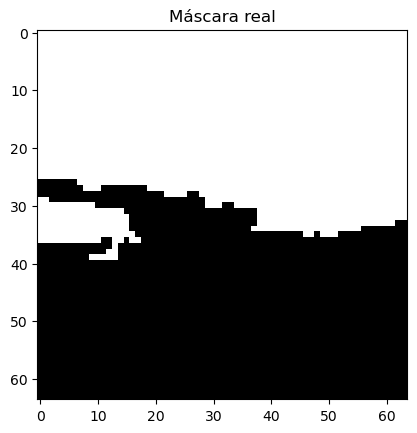

Forma da imagem de teste expandida: (1, 1, 64, 64, 12)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(1, 1, 64, 64)
(64, 64)


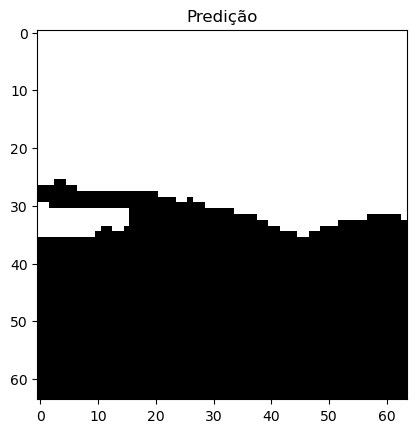

IoU: 0.9495432376861572


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU

# Selecionar a imagem de teste
id_img_teste = 120
img_teste = patche_cena_test[id_img_teste]  # Forma: (64, 64, 12)
ground_truth = patche_classe_test[id_img_teste]  # Forma: (64, 64)

# Visualizar a máscara real
plt.imshow(np.squeeze(ground_truth), cmap='gray')
plt.title('Máscara real')
plt.show()

# Expandir as dimensões da imagem de teste para o formato esperado pelo modelo
img_teste_expanded = np.expand_dims(img_teste, axis=0)  # Forma: (1, 64, 64, 12)
img_teste_expanded = np.expand_dims(img_teste_expanded, axis=0)  # Forma: (1, 1, 64, 64, 12)

# Verificar a forma da imagem expandida
print("Forma da imagem de teste expandida:", img_teste_expanded.shape)

# Realizar a predição
try:
    predictions = model.predict(img_teste_expanded)  # Forma: (1, 64, 64, num_classes)
except Exception as e:
    print("Erro ao realizar a predição:", e)
    raise

# Converter as predições para rótulos de classe
# Converter as predições para rótulos de classe
predictions = np.argmax(predictions, axis=-1)  # Forma: (1, 64, 64)
print(predictions.shape)
predictions = np.squeeze(predictions, axis=0)  # Forma: (64, 64)
predictions = np.squeeze(predictions, axis=0)  # Forma: (64, 64)
print(predictions.shape)

# Visualizar a predição
plt.imshow(predictions, cmap='gray')
plt.title('Predição')
plt.show()


# Inicializar e calcular o IoU
iou_metric = MeanIoU(num_classes=2)
ground_truth = np.expand_dims(ground_truth, axis=-1)  # Forma: (64, 64, 1)
iou_metric.update_state(ground_truth, predictions)
iou_resultado = iou_metric.result().numpy()
print(f'IoU: {iou_resultado}')

In [49]:
iou_resultado = MeanIoU(num_classes=2)
iou_resultado.update_state(ground_truth, predictions)
iou = iou_resultado.result().numpy()
print('IoU para a imagem:', iou)

IoU para a imagem: 0.94954324


In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU

def calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test):
    img_teste = patche_cena_test[id_img_teste]
    ground_truth = patche_classe_test[id_img_teste]

    iou_resultado = MeanIoU(num_classes=2)

    img_test = np.expand_dims(img_teste, axis=0)  
    img_test = np.expand_dims(img_test, axis=0)  
    predictions = model.predict(img_test)
    predictions = tf.argmax(predictions, axis=-1)

    ground_truth = ground_truth.reshape(1, 64, 64, 1)
    ground_truth = tf.cast(ground_truth, tf.int64)

    iou_resultado.update_state(ground_truth, predictions)
    iou = iou_resultado.result()

    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # axs[0].imshow(np.squeeze(ground_truth), cmap='gray')
    # axs[0].set_title('Máscara real')

    # axs[1].imshow(predictions[0], cmap='gray')
    # axs[1].set_title('Predição')

    # plt.show()

    print(f'IoU para a imagem {id_img_teste}: {iou}')

    return iou

def calcular_media_iou(model, patche_cena_test, patche_classe_test):
    valores_iou = []
    for id_img_teste in range(len(patche_cena_test)):
        iou = calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test)
        valores_iou.append(iou)

    media_iou = np.mean(valores_iou)
    print(f'Média do IoU para todas as imagens: {media_iou}')

calcular_media_iou(model, patche_cena_test, patche_classe_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 0: 0.7143197655677795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
IoU para a imagem 1: 0.8070807456970215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
IoU para a imagem 2: 0.8703272342681885
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 3: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 4: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 5: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 6: 0.9769800901412964
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 7: 0.9167687892913818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 8: 0.6632893085479736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 9: 0.5692616105079651
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 10: 0.9420114755630493
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 11: 0.8793805837631226
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 12: 0.

In [2]:
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.metrics import MeanIoU

# def calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test):
#     # Seleciona a imagem de teste e sua ground truth correspondente
#     img_teste = patche_cena_test[id_img_teste]
#     ground_truth = patche_classe_test[id_img_teste]

#     # Instancia a métrica MeanIoU para 2 classes (água e não-água)
#     iou_resultado = MeanIoU(num_classes=2)

#     # Expande as dimensões da imagem para adaptá-la ao modelo
#     img_test = np.expand_dims(img_teste, axis=0)  
#     img_test = np.expand_dims(img_test, axis=0)  
    
#     # Faz a predição da imagem com o modelo
#     predictions = model.predict(img_test)
#     predictions = tf.argmax(predictions, axis=-1)  # Converte predições para rótulos de classe

#     # Ajusta ground_truth para ter o formato correto
#     ground_truth = ground_truth.reshape(1, 64, 64, 1)
#     ground_truth = tf.cast(ground_truth, tf.int64)

#     # Calcula o IoU entre a predição e o ground truth
#     iou_resultado.update_state(ground_truth, predictions)
#     iou = iou_resultado.result().numpy()

#     print(f'IoU para a imagem {id_img_teste}: {iou}')

#     return iou

# def calcular_media_iou(model, patche_cena_test, patche_classe_test):
#     # Lista para armazenar os valores de IoU para cada imagem
#     valores_iou = []
    
#     # Itera por todas as imagens no conjunto de teste
#     for id_img_teste in range(len(patche_cena_test)):
#         iou = calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test)
#         valores_iou.append(iou)

#     # Calcula a média de IoU para todas as imagens
#     media_iou = np.mean(valores_iou)
#     print(f'mIoU: {media_iou}')

#     return media_iou

# # Chama a função para calcular a média do IoU
# media_iou_geral = calcular_media_iou(model, patche_cena_test, patche_classe_test)


In [1]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.metrics import MeanIoU

# def calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test):
#     img_teste = patche_cena_test[id_img_teste]
#     ground_truth = patche_classe_test[id_img_teste]

#     # Inicializa o objeto MeanIoU
#     iou_resultado = MeanIoU(num_classes=2)

#     # Adiciona uma dimensão extra para a previsão e para a verdade
#     img_test = np.expand_dims(img_teste, axis=0)  
#     img_test = np.expand_dims(img_test, axis=0)  
    
#     # Faz as predições
#     predictions = model.predict(img_test)
#     predictions = tf.argmax(predictions, axis=-1)

#     # Prepara a verdade para comparação
#     ground_truth = ground_truth.reshape(1, 64, 64, 1)
#     ground_truth = tf.cast(ground_truth, tf.int64)

#     # Atualiza a métrica IoU
#     iou_resultado.update_state(ground_truth, predictions)
#     iou = iou_resultado.result()

#     # Retorna a predição e a verdade para o cálculo das classes
#     return predictions, ground_truth, iou

# def calcular_media_iou(model, patche_cena_test, patche_classe_test):
#     valores_iou = []
#     # Inicializa arrays para armazenar IoUs de cada classe
#     iou_por_classe = np.zeros(2)  # Assumindo 2 classes: água (0) e não-água (1)
#     contagem = np.zeros(2)  # Contadores para cada classe

#     for id_img_teste in range(len(patche_cena_test)):
#         predictions, ground_truth, iou = calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test)
#         valores_iou.append(iou.numpy())  # Converte para numpy para armazenamento

#         # Calcula o IoU para cada classe
#         for cls in range(2):  # Para cada classe
#             # Verifica se a previsão contém a classe
#             pred_class = (predictions[0] == cls).numpy().astype(np.int32)
#             gt_class = (ground_truth[0] == cls).numpy().astype(np.int32)

#             intersection = np.sum(pred_class & gt_class)
#             union = np.sum(pred_class | gt_class)

#             if union > 0:  # Evita divisão por zero
#                 iou_por_classe[cls] += intersection / union
#                 contagem[cls] += 1

#     # Calcula a média do IoU para cada classe
#     media_iou_por_classe = iou_por_classe / (contagem + 1e-6)  # Evita divisão por zero

#     print(f'Média do IoU para cada classe: Água: {media_iou_por_classe[0]}, Não-água: {media_iou_por_classe[1]}')
#     print(f'Média do IoU geral: {np.mean(valores_iou)}')

# # Chamada da função principal
# calcular_media_iou(model, patche_cena_test, patche_classe_test)


## 9: Carregar o modelos cross validation (k=5)

In [97]:
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

- model_fold_1

In [98]:
# model_fold_1
model = load_model('model_fold_1.keras')
model.load_weights('model_fold_1.keras')

In [99]:
# Predição
y_pred = model.predict(patche_cena_test_reshaped)
y_pred_argmax = np.argmax(y_pred, axis=-1)  # Predições em termos de classe

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [100]:
# Teste separando patchs e labels do dataset
# F1-Score:
f1 = f1_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()), average='weighted')
print("F1-Score: ", f1)

# Accuracy:
acc = accuracy_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()))
print("Accuracy: ", acc)

F1-Score:  0.9211320006098799
Accuracy:  0.9203903198242187


In [269]:
def calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test):
    img_teste = patche_cena_test[id_img_teste]
    ground_truth = patche_classe_test[id_img_teste]

    iou_resultado = MeanIoU(num_classes=2)

    img_test = np.expand_dims(img_teste, axis=0)  
    img_test = np.expand_dims(img_test, axis=0)  
    predictions = model.predict(img_test)
    predictions = tf.argmax(predictions, axis=-1)

    ground_truth = ground_truth.reshape(1, 64, 64, 1)
    ground_truth = tf.cast(ground_truth, tf.int64)

    iou_resultado.update_state(ground_truth, predictions)
    iou = iou_resultado.result()

    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # axs[0].imshow(np.squeeze(ground_truth), cmap='gray')
    # axs[0].set_title('Máscara real')

    # axs[1].imshow(predictions[0], cmap='gray')
    # axs[1].set_title('Predição')

    # plt.show()

    print(f'IoU para a imagem {id_img_teste}: {iou}')

    return iou

def calcular_media_iou(model, patche_cena_test, patche_classe_test):
    valores_iou = []
    for id_img_teste in range(len(patche_cena_test)):
        iou = calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test)
        valores_iou.append(iou)

    media_iou = np.mean(valores_iou)
    print(f'Média do IoU para todas as imagens: {media_iou}')

calcular_media_iou(model, patche_cena_test, patche_classe_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
IoU para a imagem 0: 0.7611098289489746
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 1: 0.6888861656188965
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 2: 0.8087937831878662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
IoU para a imagem 3: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 4: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 5: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 6: 0.971114456653595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 7: 0.8819675445556641
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 8: 0.6985113024711609
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 9: 0.5364358425140381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 10: 0.9114851355552673
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 11: 0.8525674343109131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 12: 0.

- model_fold_2

In [270]:
# model_fold_2
model = load_model('model_fold_2.keras')
model.load_weights('model_fold_2.keras')

In [271]:
# Predição
y_pred = model.predict(patche_cena_test_reshaped)
y_pred_argmax = np.argmax(y_pred, axis=-1)  # Predições em termos de classe

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [272]:
# Teste separando patchs e labels do dataset
# F1-Score:
f1 = f1_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()), average='weighted')
print("F1-Score: ", f1)

# Accuracy:
acc = accuracy_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()))
print("Accuracy: ", acc)

F1-Score:  0.9201761640382322
Accuracy:  0.920260238647461


In [273]:
def calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test):
    img_teste = patche_cena_test[id_img_teste]
    ground_truth = patche_classe_test[id_img_teste]

    iou_resultado = MeanIoU(num_classes=2)

    img_test = np.expand_dims(img_teste, axis=0)  
    img_test = np.expand_dims(img_test, axis=0)  
    predictions = model.predict(img_test)
    predictions = tf.argmax(predictions, axis=-1)

    ground_truth = ground_truth.reshape(1, 64, 64, 1)
    ground_truth = tf.cast(ground_truth, tf.int64)

    iou_resultado.update_state(ground_truth, predictions)
    iou = iou_resultado.result()

    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # axs[0].imshow(np.squeeze(ground_truth), cmap='gray')
    # axs[0].set_title('Máscara real')

    # axs[1].imshow(predictions[0], cmap='gray')
    # axs[1].set_title('Predição')

    # plt.show()

    print(f'IoU para a imagem {id_img_teste}: {iou}')

    return iou

def calcular_media_iou(model, patche_cena_test, patche_classe_test):
    valores_iou = []
    for id_img_teste in range(len(patche_cena_test)):
        iou = calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test)
        valores_iou.append(iou)

    media_iou = np.mean(valores_iou)
    print(f'Média do IoU para todas as imagens: {media_iou}')

calcular_media_iou(model, patche_cena_test, patche_classe_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
IoU para a imagem 0: 0.7739964723587036
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 1: 0.7209991216659546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 2: 0.85985267162323
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 3: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 4: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 5: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
IoU para a imagem 6: 0.9754205942153931
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 7: 0.9224811792373657
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 8: 0.6885253190994263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 9: 0.5569842457771301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 10: 0.9422683715820312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 11: 0.8619188070297241
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 12: 0.6

- model_fold_3

In [274]:
# model_fold_3
model = load_model('model_fold_3.keras')
model.load_weights('model_fold_3.keras')

In [275]:
# Predição
y_pred = model.predict(patche_cena_test_reshaped)
y_pred_argmax = np.argmax(y_pred, axis=-1)  # Predições em termos de classe

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [276]:
# Teste separando patchs e labels do dataset
# F1-Score:
f1 = f1_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()), average='weighted')
print("F1-Score: ", f1)

# Accuracy:
acc = accuracy_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()))
print("Accuracy: ", acc)

F1-Score:  0.913913244491171
Accuracy:  0.913425064086914


In [277]:
def calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test):
    img_teste = patche_cena_test[id_img_teste]
    ground_truth = patche_classe_test[id_img_teste]

    iou_resultado = MeanIoU(num_classes=2)

    img_test = np.expand_dims(img_teste, axis=0)  
    img_test = np.expand_dims(img_test, axis=0)  
    predictions = model.predict(img_test)
    predictions = tf.argmax(predictions, axis=-1)

    ground_truth = ground_truth.reshape(1, 64, 64, 1)
    ground_truth = tf.cast(ground_truth, tf.int64)

    iou_resultado.update_state(ground_truth, predictions)
    iou = iou_resultado.result()

    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # axs[0].imshow(np.squeeze(ground_truth), cmap='gray')
    # axs[0].set_title('Máscara real')

    # axs[1].imshow(predictions[0], cmap='gray')
    # axs[1].set_title('Predição')

    # plt.show()

    print(f'IoU para a imagem {id_img_teste}: {iou}')

    return iou

def calcular_media_iou(model, patche_cena_test, patche_classe_test):
    valores_iou = []
    for id_img_teste in range(len(patche_cena_test)):
        iou = calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test)
        valores_iou.append(iou)

    media_iou = np.mean(valores_iou)
    print(f'Média do IoU para todas as imagens: {media_iou}')

calcular_media_iou(model, patche_cena_test, patche_classe_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
IoU para a imagem 0: 0.7802281975746155
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 1: 0.7091809511184692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 2: 0.8288360238075256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 3: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 4: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 5: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 6: 0.9779365062713623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 7: 0.914145827293396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 8: 0.7019565105438232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 9: 0.6004924178123474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 10: 0.9370315670967102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 11: 0.8483562469482422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 12: 0.

- model_fold_4

In [278]:
# model_fold_4
model = load_model('model_fold_4.keras')
model.load_weights('model_fold_4.keras')

In [279]:
# Predição
y_pred = model.predict(patche_cena_test_reshaped)
y_pred_argmax = np.argmax(y_pred, axis=-1)  # Predições em termos de classe

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [280]:
# Teste separando patchs e labels do dataset
# F1-Score:
f1 = f1_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()), average='weighted')
print("F1-Score: ", f1)

# Accuracy:
acc = accuracy_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()))
print("Accuracy: ", acc)

F1-Score:  0.9389223281247897
Accuracy:  0.938991928100586


In [281]:
def calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test):
    img_teste = patche_cena_test[id_img_teste]
    ground_truth = patche_classe_test[id_img_teste]

    iou_resultado = MeanIoU(num_classes=2)

    img_test = np.expand_dims(img_teste, axis=0)  
    img_test = np.expand_dims(img_test, axis=0)  
    predictions = model.predict(img_test)
    predictions = tf.argmax(predictions, axis=-1)

    ground_truth = ground_truth.reshape(1, 64, 64, 1)
    ground_truth = tf.cast(ground_truth, tf.int64)

    iou_resultado.update_state(ground_truth, predictions)
    iou = iou_resultado.result()

    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # axs[0].imshow(np.squeeze(ground_truth), cmap='gray')
    # axs[0].set_title('Máscara real')

    # axs[1].imshow(predictions[0], cmap='gray')
    # axs[1].set_title('Predição')

    # plt.show()

    print(f'IoU para a imagem {id_img_teste}: {iou}')

    return iou

def calcular_media_iou(model, patche_cena_test, patche_classe_test):
    valores_iou = []
    for id_img_teste in range(len(patche_cena_test)):
        iou = calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test)
        valores_iou.append(iou)

    media_iou = np.mean(valores_iou)
    print(f'Média do IoU para todas as imagens: {media_iou}')

calcular_media_iou(model, patche_cena_test, patche_classe_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
IoU para a imagem 0: 0.8080662488937378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 1: 0.8070807456970215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 2: 0.8609461188316345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 3: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 4: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 5: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 6: 0.9708671569824219
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
IoU para a imagem 7: 0.9116020202636719
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
IoU para a imagem 8: 0.6856115460395813
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 9: 0.4775756895542145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 10: 0.9519876837730408
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 11: 0.8452216982841492
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
IoU para a imagem 12: 0

- model_fold_5

In [282]:
# model_fold_5
model = load_model('model_fold_5.keras')
model.load_weights('model_fold_5.keras')

In [283]:
# Predição
y_pred = model.predict(patche_cena_test_reshaped)
y_pred_argmax = np.argmax(y_pred, axis=-1)  # Predições em termos de classe

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [284]:
# Teste separando patchs e labels do dataset
# F1-Score:
f1 = f1_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()), average='weighted')
print("F1-Score: ", f1)

# Accuracy:
acc = accuracy_score(list(patche_classe_test.flatten()), list(y_pred_argmax.flatten()))
print("Accuracy: ", acc)

F1-Score:  0.9372837864830477
Accuracy:  0.9373374938964844


In [285]:
def calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test):
    img_teste = patche_cena_test[id_img_teste]
    ground_truth = patche_classe_test[id_img_teste]

    iou_resultado = MeanIoU(num_classes=2)

    img_test = np.expand_dims(img_teste, axis=0)  
    img_test = np.expand_dims(img_test, axis=0)  
    predictions = model.predict(img_test)
    predictions = tf.argmax(predictions, axis=-1)

    ground_truth = ground_truth.reshape(1, 64, 64, 1)
    ground_truth = tf.cast(ground_truth, tf.int64)

    iou_resultado.update_state(ground_truth, predictions)
    iou = iou_resultado.result()

    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # axs[0].imshow(np.squeeze(ground_truth), cmap='gray')
    # axs[0].set_title('Máscara real')

    # axs[1].imshow(predictions[0], cmap='gray')
    # axs[1].set_title('Predição')

    # plt.show()

    print(f'IoU para a imagem {id_img_teste}: {iou}')

    return iou

def calcular_media_iou(model, patche_cena_test, patche_classe_test):
    valores_iou = []
    for id_img_teste in range(len(patche_cena_test)):
        iou = calcular_iou(id_img_teste, model, patche_cena_test, patche_classe_test)
        valores_iou.append(iou)

    media_iou = np.mean(valores_iou)
    print(f'Média do IoU para todas as imagens: {media_iou}')

calcular_media_iou(model, patche_cena_test, patche_classe_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
IoU para a imagem 0: 0.7809385061264038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
IoU para a imagem 1: 0.7341933250427246
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
IoU para a imagem 2: 0.8669110536575317
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
IoU para a imagem 3: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
IoU para a imagem 4: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
IoU para a imagem 5: 0.9999998807907104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
IoU para a imagem 6: 0.9739001393318176
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
IoU para a imagem 7: 0.8979611396789551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
IoU para a imagem 8: 0.7033964991569519
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
IoU para a imagem 9: 0.5335599184036255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
IoU para a imagem 10: 0.9471756219863892
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
IoU para a imagem 11: 0.8488727807998657
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
IoU para a imagem 12: 0

- média e desvio padrão

In [286]:
import numpy as np

# Valores das métricas obtidas pelos modelos gerados em cross validation
f1_scores = [0.9306, 0.9202, 0.9139, 0.9390, 0.9373]
accuracies = [0.9302, 0.9203, 0.9134, 0.9389, 0.9373]
ious = [0.7229, 0.7349, 0.7208, 0.7569, 0.7506]

In [287]:
# Cálculo da média e desvio padrão
f1_mean = np.mean(f1_scores)
f1_std = np.std(f1_scores)

accuracy_mean = np.mean(accuracies)
accuracy_std = np.std(accuracies)

iou_mean = np.mean(ious)
iou_std = np.std(ious)

# Cálculos intermediários para F1-Score
f1_diffs = (np.array(f1_scores) - f1_mean)**2
f1_variance = np.mean(f1_diffs)
f1_std_calculated = np.sqrt(f1_variance)

# Cálculos intermediários para Accuracy
accuracy_diffs = (np.array(accuracies) - accuracy_mean)**2
accuracy_variance = np.mean(accuracy_diffs)
accuracy_std_calculated = np.sqrt(accuracy_variance)

# Cálculos intermediários para IoU
iou_diffs = (np.array(ious) - iou_mean)**2
iou_variance = np.mean(iou_diffs)
iou_std_calculated = np.sqrt(iou_variance)

# Exibir os resultados
print(f'F1-Score: Média={f1_mean}, Desvio Padrão={f1_std}')
print(f'Accuracy: Média={accuracy_mean}, Desvio Padrão={accuracy_std}')
print(f'IoU: Média={iou_mean}, Desvio Padrão={iou_std}')

F1-Score: Média=0.9282, Desvio Padrão=0.009733447487915036
Accuracy: Média=0.9280200000000001, Desvio Padrão=0.009824337127765922
IoU: Média=0.73722, Desvio Padrão=0.014466430105592757



























































































































































































































































































































































































































































































































## 10: Conclusão
### A avaliação dos resultados foi melhor compreendida com a convergência do modelo de treinamento e a vizualização das segmentações dos rótudos feitas pelo algoritmo, juntamente com o método IoU (*Intersection Over Union*), foi possível visualizar a melhora das predições com os rótulos verdadeiros do conjunto de teste, portanto generalizados. Em trabalhos futuros deverá ser realizado comparações com arquiteturas de modelos que implemente redes Convolucionais e Recorrentes conectadas. Além disso, o processamento das imagens bitemporais deverão ser mais precisas, com registro (sem deslocamento) e um melhor segmento das máscaras de deslizamentos, considerando os mapas do site *Charter* [6] como verdade de campo, e uma melhor segmentação vetorizada pela biblioteca RSGISLib [7].

## Referências

  - [1] [Notebook WorkCAP Hackathon 2022](https://www.kaggle.com/code/grupohackaton2022/hackathon-notebook)
  - [2] [Python for Geosciences: Raster Merging, Clipping and Reprojection with Rasterio](https://medium.com/analytics-vidhya/python-for-geosciences-raster-merging-clipping-and-reprojection-with-rasterio-9f05f012b88a)
  - [3] [Patch Generator](https://github.com/vdlucas-queiroz/patch_generator/)
  - [4] [TensorFlow/Keras](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
  - [5] [Segmentação de Imagens com Python de A a Z](https://iaexpert.academy/cursos-online-assinatura/segmentacao-imagens-python-a-z/)
  - [6] [The International Charter Space and Major Disasters](https://disasterscharter.org/web/guest/activations/-/article/landslide-in-brazil-activation-758-)
  - [7] [RSGISLib Image Segmentation Module](http://rsgislib.org/rsgislib_segmentation.html)